In [3]:
import ampal
import gzip
import os
import re
from tqdm import tqdm
import time     
import sys
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

from concurrent.futures import ProcessPoolExecutor, as_completed
import pickle
import shutil
import nglview as nv
from cath_parsing import *
from deltaprot_search import get_decompressed_pdb
# autoreload
%load_ext autoreload
%autoreload 2
import seaborn as sns
import pymol
from pymol import cmd
import os
import pandas as pd
from retrieve_pdb_info import fetch_uniprot_accession, fetch_uniprot_details
from dpFinder.deltaprot_finder_utils import get_helix_axes
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from dpFinder.deltaprot_finder_utils import get_helix_axes
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from deltaprot_search import load_domain_as_ampal_assembly,get_cath_domains
from dpFinder.deltaprot_finder_utils import get_helix_centers_and_directions,get_helix_axes
from dpFinder.deltaprot_finder_utils import cluster_helix_axes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:


# Define functions for computing rotation invariant representations

def compute_center_distance_matrix(axes):
    """
    Computes the pairwise Euclidean distance matrix for the center points.
    This is rotation invariant.
    """
    centers = np.array([axis['center'] for axis in axes])
    # Compute pairwise differences and their norms
    diff = centers[:, np.newaxis, :] - centers[np.newaxis, :, :]
    dist_matrix = np.linalg.norm(diff, axis=-1)
    return dist_matrix

def compute_direction_similarity_matrix(axes):
    """
    Computes the pairwise dot product matrix for the normalized direction vectors.
    Since dot products (or cosine similarities) are invariant to rotation, 
    this matrix is rotation invariant.
    """
    directions = np.array([axis['direction'] for axis in axes])
    # Normalize each direction vector
    norms = np.linalg.norm(directions, axis=1, keepdims=True)
    normalized_directions = directions / norms
    # Compute pairwise dot products
    sim_matrix = np.dot(normalized_directions, normalized_directions.T)
    return sim_matrix

def plot_heatmap(matrix, title="Heatmap", xlabel="Index", ylabel="Index",vmin=None, vmax=None):
    """
    Plots a heatmap of the given matrix using Seaborn.
    """
    plt.figure(figsize=(8, 6))

    sns.heatmap(matrix, annot=False, cmap="rocket_r", square=True, vmin=vmin, vmax=vmax,)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact

def plot_heatmap_interactive(matrix, title="Heatmap", xlabel="Index", ylabel="Index"):
    # Determine the range for the sliders based on the matrix values.
    mat_min = matrix.min()
    mat_max = matrix.max()
    slider_step = (mat_max - mat_min) / 100 if (mat_max - mat_min) != 0 else 1

    def update(vmin, vmax):
        plt.figure(figsize=(8, 6))
        sns.heatmap(matrix, annot=False, cmap="rocket_r", square=True, vmin=vmin, vmax=vmax)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()
    
    interact(update,
             vmin=widgets.FloatSlider(value=mat_min, min=mat_min, max=mat_max, step=slider_step, description='vmin'),
             vmax=widgets.FloatSlider(value=mat_max, min=mat_min, max=mat_max, step=slider_step, description='vmax'))

def plot_center_distogram(dist_matrix, bins=10):
    """
    Plots a histogram (distogram) of the pairwise distances extracted from the distance matrix.
    Only the unique distances (excluding the diagonal) are used.
    """
    n = dist_matrix.shape[0]
    # Extract the upper triangular (excluding diagonal) distances
    dists = [dist_matrix[i, j] for i in range(n) for j in range(i+1, n)]
    plt.figure(figsize=(8, 6))
    sns.histplot(dists, bins=bins, kde=True)
    plt.title("Center Points Pairwise Distance Distribution")
    plt.xlabel("Distance")
    plt.ylabel("Frequency")
    plt.show()


In [ ]:
# round all centers and directions in target set


[{'center': [-11.505736513684486, 25.024140107976738, 53.692488821196164],
  'direction': [-0.05828982558091616,
   0.3413846272801703,
   -0.9381145092634084]},
 {'center': [-3.6442057651336883, 31.169073378311825, 53.52867884097224],
  'direction': [0.7320724999501955, -0.42881863163701356, 0.5293245091412548]},
 {'center': [-2.7759081378747608, 16.267042248466115, 56.65623693042623],
  'direction': [-0.7456172190329354,
   -0.5133950525239224,
   -0.42482994565537724]},
 {'center': [-5.001110907154844, 19.02112367217602, 48.056564387993475],
  'direction': [0.9893716805279337,
   0.14004330516723448,
   -0.03913502839106049]},
 {'center': [13.323162092609342, 20.224497636164223, 49.24887796651315],
  'direction': [-0.08119505025123328,
   -0.46341905192211025,
   0.8824115514488194]},
 {'center': [1.0808669225839445, 8.461181523787763, 54.69836089007956],
  'direction': [-0.6808525555459766,
   -0.32138290657245666,
   -0.6581434683787059]},
 {'center': [5.4922425251112985, 11.43353

In [121]:
import math
import numpy as np
from itertools import combinations
import plotly.graph_objects as go

# ---------------------
# Provided Data Sets
# ---------------------
query_set = [
    {'center': [-11.91, 25.92, 53.99], 'direction': [-0.1, 0.39, -0.88]}, 
    {'center': [-3.94, 31.97, 53.93], 'direction': [0.73, -0.43, 0.53]},
    {'center': [-2.78, 16.27, 56.66], 'direction': [-0.75, -0.51, -0.42]},
    {'center': [-5.0, 19.02, 48.06], 'direction': [0.99, 0.14, -0.04]},
    {'center': [13.32, 20.22, 49.25], 'direction': [-0.08, -0.46, 0.88]}
]

target_set = [
    {'center': [4.84, 3.18, 21.16], 'direction': [0.99, -0.05, -0.09]},
    {'center': [34.86, 43.09, 35.86], 'direction': [-0.55, -0.69, 0.47]},
    {'center': [30.0, 39.93, 25.88], 'direction': [0.86, 0.42, -0.3]},
    {'center': [3.82, 5.29, 0.46], 'direction': [-0.68, 0.73, -0.06]},
    {'center': [45.91, 17.24, 31.97], 'direction': [-0.55, -0.63, -0.55]},
    {'center': [1.77, -1.5, 10.53], 'direction': [-0.64, 0.72, -0.26]},
    {'center': [41.79, 31.57, 38.68], 'direction': [-0.42, -0.91, 0.0]},
    {'center': [3.84, 17.09, -4.94], 'direction': [0.97, -0.07, 0.22]},
    {'center': [5.41, -7.59, 24.43], 'direction': [-0.83, 0.41, -0.38]},
    {'center': [14.44, -0.18, 4.88], 'direction': [-0.69, 0.02, -0.73]},
    {'center': [1.61, 6.11, 38.58], 'direction': [0.87, 0.45, -0.18]},
    {'center': [15.76, 6.78, 11.67], 'direction': [1.0, -0.06, -0.07]},
    {'center': [14.27, 38.65, 4.56], 'direction': [0.89, 0.19, -0.41]},
    {'center': [12.61, 44.95, -3.86], 'direction': [-0.64, 0.04, 0.77]},
    {'center': [5.3, -4.11, 35.89], 'direction': [-0.87, -0.14, -0.47]},
    {'center': [12.39, -7.93, 14.71], 'direction': [-0.81, -0.19, -0.55]},
    {'center': [15.4, 44.74, 14.53], 'direction': [0.82, -0.04, -0.57]},
    {'center': [16.86, 32.92, -3.03], 'direction': [0.94, -0.01, -0.33]},
    {'center': [11.7, 20.95, -13.83], 'direction': [-0.8, 0.6, -0.07]},
    {'center': [2.86, -2.34, 45.42], 'direction': [-0.74, -0.43, -0.52]},
    {'center': [7.73, 8.94, -8.77], 'direction': [-0.81, 0.4, -0.44]},
    {'center': [53.63, 21.28, 17.45], 'direction': [0.9, -0.12, 0.42]},
    {'center': [5.49, 11.43, 45.53], 'direction': [0.97, -0.08, 0.24]},
    {'center': [38.57, 26.11, 28.07], 'direction': [0.76, 0.64, 0.07]},
    {'center': [28.29, 49.89, 28.95], 'direction': [-0.57, -0.6, 0.57]},
    {'center': [8.22, 20.7, 11.15], 'direction': [0.22, 0.29, -0.93]},
    {'center': [53.94, 31.75, 36.39], 'direction': [-0.34, -0.88, 0.34]},
    {'center': [-0.1, 2.87, 30.83], 'direction': [0.97, 0.24, -0.08]},
    {'center': [47.62, 12.93, 19.89], 'direction': [-0.34, 0.34, -0.88]},
    {'center': [25.8, 44.85, 19.1], 'direction': [0.83, 0.32, -0.45]},
    {'center': [47.55, 23.75, 23.23], 'direction': [0.87, 0.36, 0.33]},
    {'center': [17.44, 52.23, 6.64], 'direction': [-0.45, 0.18, 0.87]},
    {'center': [9.65, 35.45, -11.5], 'direction': [-0.61, 0.37, 0.7]},
    {'center': [-3.64, 31.17, 53.53], 'direction': [0.73, -0.43, 0.53]},
    {'center': [-2.78, 16.27, 56.66], 'direction': [-0.75, -0.51, -0.42]},
    {'center': [35.94, 33.93, 29.81], 'direction': [0.8, 0.59, -0.14]},
    {'center': [8.11, 25.7, -4.11], 'direction': [1.0, -0.07, -0.04]},
    {'center': [33.56, 33.71, 17.11], 'direction': [0.99, 0.13, 0.06]},
    {'center': [22.82, 54.62, 18.78], 'direction': [-0.59, -0.04, 0.8]},
    {'center': [19.92, 25.46, -10.53], 'direction': [-0.17, 0.46, -0.87]},
    {'center': [-5.0, 19.02, 48.06], 'direction': [0.99, 0.14, -0.04]},
    {'center': [13.34, 2.83, 31.06], 'direction': [0.79, -0.6, 0.11]},
    {'center': [9.21, 12.51, 4.58], 'direction': [0.91, -0.32, -0.27]},
    {'center': [57.82, 17.52, 29.77], 'direction': [-0.48, -0.87, -0.02]},
    {'center': [-11.51, 25.02, 53.69], 'direction': [-0.06, 0.34, -0.94]},
    {'center': [1.08, 8.46, 54.7], 'direction': [-0.68, -0.32, -0.66]},
    {'center': [13.32, 20.22, 49.25], 'direction': [-0.08, -0.46, 0.88]}
]

# ---------------------
# Utility Functions
# ---------------------
def round_set(data):
    """Round the center and direction values to 2 decimals."""
    rounded = []
    for entry in data:
        center = [round(x, 2) for x in entry['center']]
        direction = [round(x, 2) for x in entry['direction']]
        rounded.append({'center': center, 'direction': direction})
    return rounded

def compute_median_edge_length(node_set):
    """
    Compute the median Euclidean distance among all pairs of node centers,
    considering only edges with length <= 30.
    """
    distances = []
    n = len(node_set)
    for i in range(n):
        for j in range(i+1, n):
            d = np.linalg.norm(np.array(node_set[i]['center']) - np.array(node_set[j]['center']))
            if d <= 30:
                distances.append(d)
    return np.median(distances) if distances else 0

def normalize_set(node_set, median_length):
    """Normalize node centers by dividing each coordinate by the median length."""
    normalized = []
    for node in node_set:
        normalized_center = [x / median_length for x in node['center']]
        normalized.append({'center': normalized_center, 'direction': node['direction']})
    return normalized

def angle_error(d1, d2):
    """Compute the angular difference (in radians) between two direction vectors."""
    v1 = np.array(d1) / np.linalg.norm(d1)
    v2 = np.array(d2) / np.linalg.norm(d2)
    dot = np.clip(np.dot(v1, v2), -1.0, 1.0)
    return math.acos(dot)

def compute_invariants(node_set, median_length):
    """
    Compute an invariant representation for a node set.
    For every pair (i, j) with i < j, compute:
      - d_norm: normalized Euclidean distance between centers.
      - a: crossing angle between direction vectors.
    Returns a dictionary with keys (i, j) and values (d_norm, a).
    """
    invariants = {}
    n = len(node_set)
    for i in range(n):
        for j in range(i+1, n):
            d = np.linalg.norm(np.array(node_set[i]['center']) - np.array(node_set[j]['center']))
            d_norm = d / median_length if median_length != 0 else d
            a = angle_error(node_set[i]['direction'], node_set[j]['direction'])
            invariants[(i, j)] = (d_norm, a)
    return invariants

def geometric_hashing_match(query_set, target_set, tol_dist, tol_angle):
    """
    Use geometric hashing to match a small query graph to a larger target graph.
    Both graphs are represented solely by pairwise invariants.
    
    Returns:
      best_mapping: dictionary mapping query indices to target indices,
      best_error: total matching error.
    """
    # Compute medians for normalization (for invariant computation)
    median_query = compute_median_edge_length(query_set)
    median_target = compute_median_edge_length(target_set)
    
    # Compute invariant representations
    q_invs = compute_invariants(query_set, median_query)
    t_invs = compute_invariants(target_set, median_target)
    
    n_query = len(query_set)
    n_target = len(target_set)
    best_mapping = None
    best_error = float('inf')
    
    # Use the first pair of query nodes as the base pair.
    base_pair = (0, 1)
    q_base_inv = q_invs[base_pair]
    
    # Find candidate base pairs in the target graph whose invariants match the query base pair.
    candidate_bases = []
    for (i, j), t_inv in t_invs.items():
        if abs(t_inv[0] - q_base_inv[0]) <= tol_dist and abs(t_inv[1] - q_base_inv[1]) <= tol_angle:
            candidate_bases.append((i, j))
    
    # Backtracking function to extend a partial mapping.
    def backtrack(mapping, used_target):
        nonlocal best_mapping, best_error
        if len(mapping) == n_query:
            total_error = 0
            for (i, j), q_inv in q_invs.items():
                t_pair = tuple(sorted((mapping[i], mapping[j])))
                if t_pair not in t_invs:
                    return
                t_inv = t_invs[t_pair]
                total_error += abs(q_inv[0] - t_inv[0]) + abs(q_inv[1] - t_inv[1])
            if total_error < best_error:
                best_error = total_error
                best_mapping = mapping.copy()
            return
        
        next_q = max(mapping.keys()) + 1 if mapping else 0
        for candidate in range(n_target):
            if candidate in used_target:
                continue
            valid = True
            for q_idx, t_idx in mapping.items():
                q_pair = tuple(sorted((q_idx, next_q)))
                if q_pair not in q_invs:
                    continue
                q_inv = q_invs[q_pair]
                t_pair = tuple(sorted((t_idx, candidate)))
                if t_pair not in t_invs:
                    valid = False
                    break
                t_inv = t_invs[t_pair]
                if abs(q_inv[0] - t_inv[0]) > tol_dist or abs(q_inv[1] - t_inv[1]) > tol_angle:
                    valid = False
                    break
            if valid:
                mapping[next_q] = candidate
                used_target.add(candidate)
                backtrack(mapping, used_target)
                del mapping[next_q]
                used_target.remove(candidate)
    
    # For each candidate base pair, initialize the mapping with query nodes 0 and 1.
    for base in candidate_bases:
        mapping = {0: base[0], 1: base[1]}
        used_target = set(base)
        backtrack(mapping, used_target)
    
    return best_mapping, best_error

def plot_3d_outcome(target_set, query_set, match_indices, arrow_scale=1):
    """
    Visualizes target (blue) and query (red) nodes in 3D.
    Arrows indicate direction vectors.
    Dashed green lines connect matched query and target nodes.
    """
    target_x = [node['center'][0] for node in target_set]
    target_y = [node['center'][1] for node in target_set]
    target_z = [node['center'][2] for node in target_set]
    
    query_x = [node['center'][0] for node in query_set]
    query_y = [node['center'][1] for node in query_set]
    query_z = [node['center'][2] for node in query_set]
    
    fig = go.Figure()
    
    # Target markers
    fig.add_trace(go.Scatter3d(
        x=target_x, y=target_y, z=target_z,
        mode='markers',
        marker=dict(size=5, color='blue'),
        name='Target Nodes'
    ))
    # Query markers
    fig.add_trace(go.Scatter3d(
        x=query_x, y=query_y, z=query_z,
        mode='markers',
        marker=dict(size=7, color='red'),
        name='Query Nodes'
    ))
    
    # Plot direction arrows for query nodes
    for node in query_set:
        cx, cy, cz = node['center']
        dx, dy, dz = node['direction']
        ex, ey, ez = cx + arrow_scale * dx, cy + arrow_scale * dy, cz + arrow_scale * dz
        fig.add_trace(go.Scatter3d(
            x=[cx, ex],
            y=[cy, ey],
            z=[cz, ez],
            mode='lines',
            line=dict(color='red', width=4),
            showlegend=False
        ))
    
    # Plot direction arrows for target nodes
    for node in target_set:
        cx, cy, cz = node['center']
        dx, dy, dz = node['direction']
        ex, ey, ez = cx + arrow_scale * dx, cy + arrow_scale * dy, cz + arrow_scale * dz
        fig.add_trace(go.Scatter3d(
            x=[cx, ex],
            y=[cy, ey],
            z=[cz, ez],
            mode='lines',
            line=dict(color='blue', width=2),
            showlegend=False
        ))
    
    # Draw match lines connecting query nodes to target nodes.
    for q_idx, t_idx in match_indices.items():
        q_node = query_set[q_idx]
        t_node = target_set[t_idx]
        qx, qy, qz = q_node['center']
        tx, ty, tz = t_node['center']
        fig.add_trace(go.Scatter3d(
            x=[qx, tx],
            y=[qy, ty],
            z=[qz, tz],
            mode='lines',
            line=dict(color='green', width=4, dash='dash'),
            name='Match' if q_idx == list(match_indices.keys())[0] else None,
            showlegend=(q_idx == list(match_indices.keys())[0])
        ))
    
    fig.update_layout(
        scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
        title='3D Visualization of Target and Query Sets with Matches'
    )
    fig.show()

# ---------------------
# Main Execution
# ---------------------

# Step 1: Round the sets

query_set_rounded = round_set(query_set)
target_set_rounded = round_set(target_set)

# Step 2: Compute median edge lengths (ignoring edges > 30)
median_query = compute_median_edge_length(query_set_rounded)
median_target = compute_median_edge_length(target_set_rounded)
print("Median edge length of query set:", median_query)
print("Median edge length of target set:", median_target)

# ***** If you do NOT want to scale, simply skip the normalization step *****
# Instead of normalizing, we use the original rounded sets:
query_graph = query_set_rounded
target_graph = target_set_rounded

# Step 3: Set tolerances for the invariant differences.
# Now, tolerances are in the absolute scale of your data.
tolerance_distance = 3.0  # adjust based on your expected distances
tolerance_angle = 0.9     # angle tolerance in radians

# Step 4: Perform the geometric hashing match.
mapping, total_error = geometric_hashing_match(query_graph, target_graph, tolerance_distance, tolerance_angle)

print("\nMapping (query index -> target index):", mapping)
print("Total matching error:", total_error)

# Step 5: Visualize the outcome using Plotly.
plot_3d_outcome(target_graph, query_graph, mapping, arrow_scale=1)


Median edge length of query set: 15.117742448725195
Median edge length of target set: 19.288566561566984

Mapping (query index -> target index): {0: 13, 1: 17, 2: 18, 3: 7, 4: 25}
Total matching error: 4.9033311641235695


In [153]:
import math
import numpy as np
from itertools import combinations
import plotly.graph_objects as go

# ---------------------
# Provided Data Sets
# ---------------------
query_set = [{'center': [-2.19, 5.79, -1.85], 'direction': [-0.43, -0.5, -0.75]},
 {'center': [-4.24, -4.52, 1.84], 'direction': [0.54, -0.61, -0.58]},
 {'center': [6.2, -0.6, 1.74], 'direction': [0.2, 0.24, -0.95]}]

target_set = [
    {'center': [4.84, 3.18, 21.16], 'direction': [0.99, -0.05, -0.09]},
    {'center': [34.86, 43.09, 35.86], 'direction': [-0.55, -0.69, 0.47]},
    {'center': [30.0, 39.93, 25.88], 'direction': [0.86, 0.42, -0.3]},
    {'center': [3.82, 5.29, 0.46], 'direction': [-0.68, 0.73, -0.06]},
    {'center': [45.91, 17.24, 31.97], 'direction': [-0.55, -0.63, -0.55]},
    {'center': [1.77, -1.5, 10.53], 'direction': [-0.64, 0.72, -0.26]},
    {'center': [41.79, 31.57, 38.68], 'direction': [-0.42, -0.91, 0.0]},
    {'center': [3.84, 17.09, -4.94], 'direction': [0.97, -0.07, 0.22]},
    {'center': [5.41, -7.59, 24.43], 'direction': [-0.83, 0.41, -0.38]},
    {'center': [14.44, -0.18, 4.88], 'direction': [-0.69, 0.02, -0.73]},
    {'center': [1.61, 6.11, 38.58], 'direction': [0.87, 0.45, -0.18]},
    {'center': [15.76, 6.78, 11.67], 'direction': [1.0, -0.06, -0.07]},
    {'center': [14.27, 38.65, 4.56], 'direction': [0.89, 0.19, -0.41]},
    {'center': [12.61, 44.95, -3.86], 'direction': [-0.64, 0.04, 0.77]},
    {'center': [5.3, -4.11, 35.89], 'direction': [-0.87, -0.14, -0.47]},
    {'center': [12.39, -7.93, 14.71], 'direction': [-0.81, -0.19, -0.55]},
    {'center': [15.4, 44.74, 14.53], 'direction': [0.82, -0.04, -0.57]},
    {'center': [16.86, 32.92, -3.03], 'direction': [0.94, -0.01, -0.33]},
    {'center': [11.7, 20.95, -13.83], 'direction': [-0.8, 0.6, -0.07]},
    {'center': [2.86, -2.34, 45.42], 'direction': [-0.74, -0.43, -0.52]},
    {'center': [7.73, 8.94, -8.77], 'direction': [-0.81, 0.4, -0.44]},
    {'center': [53.63, 21.28, 17.45], 'direction': [0.9, -0.12, 0.42]},
    {'center': [5.49, 11.43, 45.53], 'direction': [0.97, -0.08, 0.24]},
    {'center': [38.57, 26.11, 28.07], 'direction': [0.76, 0.64, 0.07]},
    {'center': [28.29, 49.89, 28.95], 'direction': [-0.57, -0.6, 0.57]},
    {'center': [8.22, 20.7, 11.15], 'direction': [0.22, 0.29, -0.93]},
    {'center': [53.94, 31.75, 36.39], 'direction': [-0.34, -0.88, 0.34]},
    {'center': [-0.1, 2.87, 30.83], 'direction': [0.97, 0.24, -0.08]},
    {'center': [47.62, 12.93, 19.89], 'direction': [-0.34, 0.34, -0.88]},
    {'center': [25.8, 44.85, 19.1], 'direction': [0.83, 0.32, -0.45]},
    {'center': [47.55, 23.75, 23.23], 'direction': [0.87, 0.36, 0.33]},
    {'center': [17.44, 52.23, 6.64], 'direction': [-0.45, 0.18, 0.87]},
    {'center': [9.65, 35.45, -11.5], 'direction': [-0.61, 0.37, 0.7]},
    {'center': [-3.64, 31.17, 53.53], 'direction': [0.73, -0.43, 0.53]},
    {'center': [-2.78, 16.27, 56.66], 'direction': [-0.75, -0.51, -0.42]},
    {'center': [35.94, 33.93, 29.81], 'direction': [0.8, 0.59, -0.14]},
    {'center': [8.11, 25.7, -4.11], 'direction': [1.0, -0.07, -0.04]},
    {'center': [33.56, 33.71, 17.11], 'direction': [0.99, 0.13, 0.06]},
    {'center': [22.82, 54.62, 18.78], 'direction': [-0.59, -0.04, 0.8]},
    {'center': [19.92, 25.46, -10.53], 'direction': [-0.17, 0.46, -0.87]},
    {'center': [-5.0, 19.02, 48.06], 'direction': [0.99, 0.14, -0.04]},
    {'center': [13.34, 2.83, 31.06], 'direction': [0.79, -0.6, 0.11]},
    {'center': [9.21, 12.51, 4.58], 'direction': [0.91, -0.32, -0.27]},
    {'center': [57.82, 17.52, 29.77], 'direction': [-0.48, -0.87, -0.02]},
    {'center': [-11.51, 25.02, 53.69], 'direction': [-0.06, 0.34, -0.94]},
    {'center': [1.08, 8.46, 54.7], 'direction': [-0.68, -0.32, -0.66]},
    {'center': [13.32, 20.22, 49.25], 'direction': [-0.08, -0.46, 0.88]}
]

# ---------------------
# Utility Functions
# ---------------------
def round_set(data):
    """Round the center and direction values to 2 decimals."""
    rounded = []
    for entry in data:
        center = [round(x, 2) for x in entry['center']]
        direction = [round(x, 2) for x in entry['direction']]
        rounded.append({'center': center, 'direction': direction})
    return rounded

def compute_median_edge_length(node_set):
    """
    Compute the median Euclidean distance among all pairs of node centers,
    considering only edges with length <= 30.
    """
    distances = []
    n = len(node_set)
    for i in range(n):
        for j in range(i+1, n):
            d = np.linalg.norm(np.array(node_set[i]['center']) - np.array(node_set[j]['center']))
            if d <= 30:
                distances.append(d)
    return np.median(distances) if distances else 0

def normalize_set(node_set, median_length):
    """Normalize node centers by dividing each coordinate by the median length."""
    normalized = []
    for node in node_set:
        normalized_center = [x / median_length for x in node['center']]
        normalized.append({'center': normalized_center, 'direction': node['direction']})
    return normalized

def angle_error(d1, d2):
    """Compute the angular difference (in radians) between two direction vectors."""
    v1 = np.array(d1) / np.linalg.norm(d1)
    v2 = np.array(d2) / np.linalg.norm(d2)
    dot = np.clip(np.dot(v1, v2), -1.0, 1.0)
    return math.acos(dot)

def compute_invariants(node_set, median_length):
    """
    Compute an invariant representation for a node set.
    For every pair (i, j) with i < j, compute:
      - d_norm: normalized Euclidean distance between centers.
      - a: crossing angle between direction vectors.
    Returns a dictionary with keys (i, j) and values (d_norm, a).
    """
    invariants = {}
    n = len(node_set)
    for i in range(n):
        for j in range(i+1, n):
            d = np.linalg.norm(np.array(node_set[i]['center']) - np.array(node_set[j]['center']))
            d_norm = d / median_length if median_length != 0 else d
            a = angle_error(node_set[i]['direction'], node_set[j]['direction'])
            invariants[(i, j)] = (d_norm, a)
    return invariants

def geometric_hashing_match(query_set, target_set, tol_dist, tol_angle):
    """
    Use geometric hashing to match a small query graph to a larger target graph.
    Both graphs are represented solely by pairwise invariants.
    
    Returns:
      best_mapping: dictionary mapping query indices to target indices,
      best_error: total matching error.
    """
    # Compute medians for invariant computation (but we don't scale the actual coordinates)
    median_query = compute_median_edge_length(query_set)
    median_target = compute_median_edge_length(target_set)
    
    # Compute invariant representations
    q_invs = compute_invariants(query_set, median_query)
    t_invs = compute_invariants(target_set, median_target)
    
    n_query = len(query_set)
    n_target = len(target_set)
    best_mapping = None
    best_error = float('inf')
    
    # Use the first pair of query nodes as the base pair.
    base_pair = (0, 1)
    q_base_inv = q_invs[base_pair]
    
    # Find candidate base pairs in the target graph whose invariants match the query base pair.
    candidate_bases = []
    for (i, j), t_inv in t_invs.items():
        if abs(t_inv[0] - q_base_inv[0]) <= tol_dist and abs(t_inv[1] - q_base_inv[1]) <= tol_angle:
            candidate_bases.append((i, j))
    
    # Backtracking function to extend a partial mapping.
    def backtrack(mapping, used_target):
        nonlocal best_mapping, best_error
        if len(mapping) == n_query:
            total_error = 0
            for (i, j), q_inv in q_invs.items():
                t_pair = tuple(sorted((mapping[i], mapping[j])))
                if t_pair not in t_invs:
                    return
                t_inv = t_invs[t_pair]
                total_error += abs(q_inv[0] - t_inv[0]) + abs(q_inv[1] - t_inv[1])
            if total_error < best_error:
                best_error = total_error
                best_mapping = mapping.copy()
            return
        
        next_q = max(mapping.keys()) + 1 if mapping else 0
        for candidate in range(n_target):
            if candidate in used_target:
                continue
            valid = True
            for q_idx, t_idx in mapping.items():
                q_pair = tuple(sorted((q_idx, next_q)))
                if q_pair not in q_invs:
                    continue
                q_inv = q_invs[q_pair]
                t_pair = tuple(sorted((t_idx, candidate)))
                if t_pair not in t_invs:
                    valid = False
                    break
                t_inv = t_invs[t_pair]
                if abs(q_inv[0] - t_inv[0]) > tol_dist or abs(q_inv[1] - t_inv[1]) > tol_angle:
                    valid = False
                    break
            if valid:
                mapping[next_q] = candidate
                used_target.add(candidate)
                backtrack(mapping, used_target)
                del mapping[next_q]
                used_target.remove(candidate)
    
    # For each candidate base pair, initialize the mapping with query nodes 0 and 1.
    for base in candidate_bases:
        mapping = {0: base[0], 1: base[1]}
        used_target = set(base)
        backtrack(mapping, used_target)
    
    return best_mapping, best_error

def plot_3d_outcome(target_set, query_set, match_indices, arrow_scale=1):
    """
    Visualizes target (blue) and query (red) nodes in 3D.
    Arrows indicate direction vectors.
    Dashed green lines connect matched query and target nodes.
    """
    target_x = [node['center'][0] for node in target_set]
    target_y = [node['center'][1] for node in target_set]
    target_z = [node['center'][2] for node in target_set]
    
    query_x = [node['center'][0] for node in query_set]
    query_y = [node['center'][1] for node in query_set]
    query_z = [node['center'][2] for node in query_set]
    
    fig = go.Figure()
    
    # Target markers
    fig.add_trace(go.Scatter3d(
        x=target_x, y=target_y, z=target_z,
        mode='markers',
        marker=dict(size=5, color='blue'),
        name='Target Nodes'
    ))
    # Query markers
    fig.add_trace(go.Scatter3d(
        x=query_x, y=query_y, z=query_z,
        mode='markers',
        marker=dict(size=7, color='red'),
        name='Query Nodes'
    ))
    
    # Plot direction arrows for query nodes
    for node in query_set:
        cx, cy, cz = node['center']
        dx, dy, dz = node['direction']
        ex, ey, ez = cx + arrow_scale * dx, cy + arrow_scale * dy, cz + arrow_scale * dz
        fig.add_trace(go.Scatter3d(
            x=[cx, ex],
            y=[cy, ey],
            z=[cz, ez],
            mode='lines',
            line=dict(color='red', width=4),
            showlegend=False
        ))
    
    # Plot direction arrows for target nodes
    for node in target_set:
        cx, cy, cz = node['center']
        dx, dy, dz = node['direction']
        ex, ey, ez = cx + arrow_scale * dx, cy + arrow_scale * dy, cz + arrow_scale * dz
        fig.add_trace(go.Scatter3d(
            x=[cx, ex],
            y=[cy, ey],
            z=[cz, ez],
            mode='lines',
            line=dict(color='blue', width=2),
            showlegend=False
        ))
    
    # Draw match lines connecting query nodes to target nodes.
    for q_idx, t_idx in match_indices.items():
        q_node = query_set[q_idx]
        t_node = target_set[t_idx]
        qx, qy, qz = q_node['center']
        tx, ty, tz = t_node['center']
        fig.add_trace(go.Scatter3d(
            x=[qx, tx],
            y=[qy, ty],
            z=[qz, tz],
            mode='lines',
            line=dict(color='green', width=4, dash='dash'),
            name='Match' if q_idx == list(match_indices.keys())[0] else None,
            showlegend=(q_idx == list(match_indices.keys())[0])
        ))
    
    fig.update_layout(
        scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
        title='3D Visualization of Target and Query Sets with Matches'
    )
    fig.show()

# ---------------------
# Kabsch Algorithm
# ---------------------
def kabsch(P, Q):
    """
    Compute the optimal rotation matrix R and translation vector t
    that aligns P to Q, using the Kabsch algorithm.
    
    P and Q are numpy arrays of shape (N, 3) corresponding to matched points.
    Returns:
       R: a 3x3 rotation matrix,
       t: a 1x3 translation vector.
    """
    centroid_P = np.mean(P, axis=0)
    centroid_Q = np.mean(Q, axis=0)
    P_centered = P - centroid_P
    Q_centered = Q - centroid_Q
    H = P_centered.T @ Q_centered
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    # Reflection correction:
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T
    t = centroid_Q - R @ centroid_P
    return R, t

# ---------------------
# Main Execution
# ---------------------

# Step 1: Round the sets
query_set_rounded = round_set(query_set)
target_set_rounded = round_set(target_set)

# Step 2: Compute median edge lengths (ignoring edges > 30) for invariant calculation
median_query = compute_median_edge_length(query_set_rounded)
median_target = compute_median_edge_length(target_set_rounded)
print("Median edge length of query set:", median_query)
print("Median edge length of target set:", median_target)

# Since we don't want to scale the data, we use the original rounded sets as our graphs.
query_graph = query_set_rounded
target_graph = target_set_rounded

# Step 3: Set tolerances for the invariant differences.
tolerance_distance = 0.3  # absolute distance tolerance
tolerance_angle = 0.4     # angle tolerance in radians

# Step 4: Perform the geometric hashing match.
mapping, total_error = geometric_hashing_match(query_graph, target_graph, tolerance_distance, tolerance_angle)
print("\nMapping (query index -> target index):", mapping)
print("Total matching error:", total_error)

# Step 5: Use the Kabsch algorithm to align the matched query points to the target.
if mapping is not None:
    # Collect corresponding centers based on the mapping.
    P = []
    Q = []
    for q_idx, t_idx in mapping.items():
        P.append(query_graph[q_idx]['center'])
        Q.append(target_graph[t_idx]['center'])
    P = np.array(P)
    Q = np.array(Q)
    R, t = kabsch(P, Q)
    
    # Apply the transformation to all query graph nodes.
    aligned_query_graph = []
    for node in query_graph:
        orig_center = np.array(node['center'])
        # Transform center: rotate and translate.
        new_center = R @ orig_center + t
        # Transform direction: only rotation is applied.
        orig_dir = np.array(node['direction'])
        new_direction = R @ orig_dir
        # Store the transformed node.
        aligned_query_graph.append({
            'center': new_center.tolist(),
            'direction': new_direction.tolist()
        })
    
    # Step 6: Visualize the outcome using Plotly.
    # Now, aligned_query_graph is the query graph after Kabsch alignment.
    plot_3d_outcome(target_graph, aligned_query_graph, mapping, arrow_scale=5)
else:
    print("No valid mapping found.")


Median edge length of query set: 11.140677717266575
Median edge length of target set: 19.288566561566984

Mapping (query index -> target index): {0: 5, 1: 9, 2: 25}
Total matching error: 1.0549388543978782


In [114]:
query_set_rounded

[{'center': [-11.91, 25.92, 53.99], 'direction': [-0.1, 0.39, -0.88]},
 {'center': [-3.94, 31.97, 53.93], 'direction': [0.73, -0.43, 0.53]},
 {'center': [-2.78, 16.27, 56.66], 'direction': [-0.75, -0.51, -0.42]},
 {'center': [-5.0, 19.02, 48.06], 'direction': [0.99, 0.14, -0.04]},
 {'center': [13.32, 20.22, 49.25], 'direction': [-0.08, -0.46, 0.88]}]

In [148]:
helix_data = get_helix_axes("/home/tadas/code/deltaProteinSearch/outputs/best_hits_per_orientation/b3iii/b3iii.pdb")
round_set(helix_data)

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


[{'center': [-2.19, 5.79, -1.85], 'direction': [-0.43, -0.5, -0.75]},
 {'center': [-4.24, -4.52, 1.84], 'direction': [0.54, -0.61, -0.58]},
 {'center': [6.2, -0.6, 1.74], 'direction': [0.2, 0.24, -0.95]}]

In [124]:
helix_data = get_helix_axes("/home/tadas/code/deltaProteinSearch/outputs/best_hits_per_orientation/b4innn/b4innn.pdb")
helix_data

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


[{'center': [2.6749584938487545, -6.830517832758575, -2.49226046822084],
  'direction': [0.04600402745498314, 0.6928025131710444, -0.7196584656639607]},
 {'center': [-6.3642168565816, -1.7282460762174616, -3.2869211482224188],
  'direction': [0.14266569572836404, 0.9856099802046261, 0.09066127168410199]},
 {'center': [-2.3241148456082312, 2.6322390079342672, 6.501603555291026],
  'direction': [0.31982804320690256,
   0.9471568157669941,
   0.024576190196455173]},
 {'center': [5.983949708400443, 3.7779152068330517, 0.2879365170844946],
  'direction': [-0.15178199203340378,
   0.7505302451463142,
   -0.6431691674940468]}]

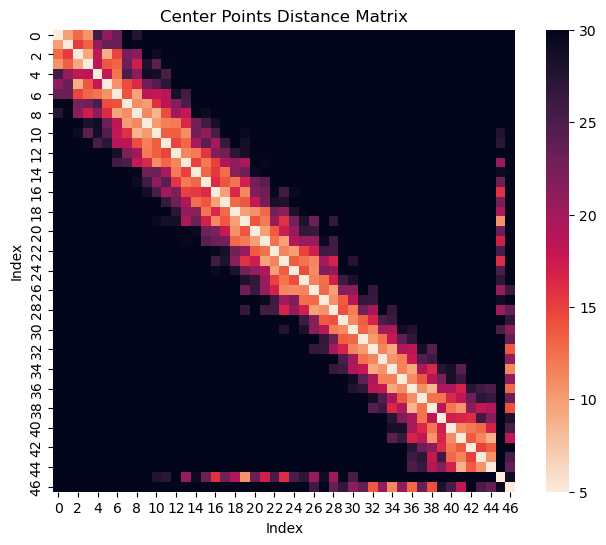

In [ ]:
from dpFinder.cluster_helix_data import plot_clusters


# helix_data = get_helix_axes("/home/tadas/code/random/dp_like_protein/2p8q.pdb")
plot_clusters(helix_data)


# print(helix_data)
# # Compute clusters using the defined parameters.
# clusters = cluster_helix_axes(helix_data, min_cluster_size=3, cluster_distance=30, neighbor_distance=17, 
#                     n_must_neighbors=2, far_multiplier=2.5, close_multiplier=0.5, angle_tolerance=30,max_members=8)


# cluster_indices_list = [cluster['indices'] for cluster in clusters]
# print(cluster_indices_list)
# print("Valid clusters:")
# for i, cluster in enumerate(clusters):
#     print(f"Cluster {i+1}: Helix indices: {cluster['indices']}, Sphere center: {cluster['sphere_center']}, Sphere radius: {cluster['sphere_radius']}")

# # Plot the helices and clusters.
# plot_clusters(helix_data, clusters)
center_dist_matrix = compute_center_distance_matrix(helix_data)
direction_sim_matrix = compute_direction_similarity_matrix(helix_data)
plot_heatmap(center_dist_matrix, title="Center Points Distance Matrix", vmin=5, vmax=30)
{0: 32, 1: 42, 2: 24, 3: 37, 4: 44}


In [12]:
plot_heatmap_interactive(center_dist_matrix, title="Center Points Distance Matrix")

interactive(children=(FloatSlider(value=0.0, description='vmin', max=74.63188459142097, step=0.746318845914209…

In [39]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster

def refine_cluster(indices, centers, complete_threshold, min_participants):
    """
    Recursively refines a candidate cluster (given by indices) so that:
      - Points with distance > 2×median from the centroid are automatically removed.
      - If any point is too close (< 0.5×median), we try alternative refined clusters by removing it.
    Returns a list of refined clusters (each is a list of indices).
    """
    if len(indices) < min_participants:
        return []
    
    # Compute the centroid and distances.
    sub_centers = centers[indices]
    centroid = np.mean(sub_centers, axis=0)
    dists = np.linalg.norm(sub_centers - centroid, axis=1)
    median_dist = np.median(dists)
    if median_dist == 0:
        # All points coincide; check complete threshold condition.
        if np.max(pdist(sub_centers)) <= complete_threshold:
            return [indices]
        else:
            return []
    
    # Automatically remove points that are too far.
    indices_far_removed = [idx for idx, d in zip(indices, dists) if d <= 2.0 * median_dist]
    if len(indices_far_removed) < min_participants:
        return []
    
    # Recompute with the far-removed set.
    sub_centers = centers[indices_far_removed]
    centroid = np.mean(sub_centers, axis=0)
    dists = np.linalg.norm(sub_centers - centroid, axis=1)
    median_dist = np.median(dists)
    
    # Identify points that are too close.
    too_close = [idx for idx, d in zip(indices_far_removed, dists) if d < 0.5 * median_dist]
    
    # If none are too close, check that every pair is within the complete_threshold.
    if not too_close:
        if np.max(pdist(sub_centers)) <= complete_threshold:
            return [indices_far_removed]
        else:
            return []
    
    # Otherwise, try removing each too-close point (one at a time) and refine recursively.
    valid = set()
    for pt in too_close:
        new_indices = [x for x in indices_far_removed if x != pt]
        refined = refine_cluster(new_indices, centers, complete_threshold, min_participants)
        for r in refined:
            valid.add(tuple(sorted(r)))
    
    return [list(t) for t in valid]

def cluster_helix_axes(
    helix_data,
    complete_threshold=30.0,
    neighbor_distance=15.0,
    min_neighbors=2,
    min_participants=3
):
    """
    Clusters helix axes based on distance criteria and then refines each candidate cluster.
    
    Steps:
      1. Filter out helices that don't have at least `min_neighbors` neighbors within `neighbor_distance`.
      2. Use hierarchical clustering (complete linkage) with a cutoff of `complete_threshold`
         to form candidate clusters.
      3. For each candidate cluster, re-check neighbor counts.
      4. Recursively refine the candidate:
           - Automatically remove points that are too far (distance > 2× median).
           - If any point is too close (< 0.5× median), try alternative refined clusters by removing it.
         Only clusters that satisfy the complete_threshold condition (every pair is within the threshold)
         and have at least `min_participants` are returned.
         
    Returns:
      A list of clusters (lists of helix indices). Helices may appear in more than one cluster.
    """
    centers = np.array([h["center"] for h in helix_data])
    N = len(centers)
    if N < 2:
        return []

    # Compute full distance matrix.
    full_distances = squareform(pdist(centers))

    # Initial filter: keep indices with at least min_neighbors within neighbor_distance.
    initial_valid = [
        i for i in range(N)
        if np.sum(full_distances[i] < neighbor_distance) - 1 >= min_neighbors
    ]
    if len(initial_valid) < min_participants:
        return []

    # Hierarchical clustering on filtered centers.
    filtered_centers = centers[initial_valid]
    if len(filtered_centers) < min_participants:
        return []

    try:
        Z = linkage(filtered_centers, method='complete')
    except Exception as e:
        print("Error in clustering:", e)
        return []

    # Assign cluster labels based on complete_threshold.
    cluster_labels = fcluster(Z, t=complete_threshold, criterion='distance')

    # Group original indices by cluster label.
    clusters_dict = {}
    for orig_idx, label in zip(initial_valid, cluster_labels):
        clusters_dict.setdefault(label, []).append(orig_idx)

    valid_clusters = []
    # Process each candidate cluster.
    for cluster_indices in clusters_dict.values():
        if len(cluster_indices) < min_participants:
            continue
        
        # Re-check neighbor counts within this candidate.
        cluster_centers = centers[cluster_indices]
        cluster_dists = squareform(pdist(cluster_centers))
        neighbor_counts = np.sum(cluster_dists < neighbor_distance, axis=1) - 1
        neighbor_filtered = [
            cluster_indices[i]
            for i, count in enumerate(neighbor_counts)
            if count >= min_neighbors
        ]
        if len(neighbor_filtered) < min_participants:
            continue

        # Refine the candidate cluster.
        refined_clusters = refine_cluster(neighbor_filtered, centers, complete_threshold, min_participants)
        for rc in refined_clusters:
            # Final check: every pair must be within complete_threshold.
            if len(rc) >= min_participants and np.max(pdist(centers[rc])) <= complete_threshold:
                valid_clusters.append(rc)

    return valid_clusters

# Provided helix data
helix_data = [
    {'center': [25.398865768441148, -8.702599259395209, -13.00039628804494]},
    {'center': [24.483299529453124, -11.44523897944008, -4.088373892205599]},
    {'center': [34.67494790099142, 6.573112200153498, -4.6793853721111445]},
    {'center': [38.83620441197158, 1.7078077762305282, 4.57085974446416]},
    {'center': [18.431817646855688, -2.4873452195664547, 0.8059264920338043]},
    {'center': [17.75908504931877, 6.647812371697722, -9.210376122167544]},
    {'center': [22.052927558050055, -3.8458216580289295, -10.110889368872858]},
    {'center': [8.506751291352158, -5.880737496516375, -4.36001578062656]},
]

# Run the clustering function on the provided data.
clusters = cluster_helix_axes(helix_data)
print("Clusters:", clusters)


Clusters: [[0, 1, 4, 5, 7]]


In [ ]:


df = get_cath_domains()
assembly = load_domain_as_ampal_assembly(df[(df["pdb_code"] == "107l") & (df["domain"] == "A00")].iloc[0])


In [27]:


helix_axes = get_helix_axes(assembly=assembly)

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


In [29]:


clusters=cluster_helix_axes(helix_axes)

Max pair distance: 26.7809422538453, cluster size: 10, 


In [30]:
len(clusters[0])

10

In [ ]:
# find where domain = "A00", pdb = "111l"

df[(df["pdb_code"] == "111l") & (df["domain"] == "A00")]

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter
import io

In [16]:
df = pd.read_pickle("/home/tadas/code/deltaProteinSearch/outputs/filtered_cath_deltaprots.pkl")
df.columns

Index(['filename', 'helix_axes', 'orientation_code', 'rotation_matrix',
       'primary_scale', 'fine_scale', 'total_scale', 'translation_matrix',
       'sliding_rmsd', 'rmsd', 'best_angle_error', 'assignment_indices',
       'transformed_orientation_data', 'total_unassigned_axes', 'total_cost'],
      dtype='object')

In [25]:
for index, row in df.iterrows():
    axes = row['helix_axes']
    if len(axes) >=6:
        break


In [59]:
%prun get_helix_axes("/home/tadas/code/deltaProteinSearch/outputs/best_hits_per_orientation/b5ininn/b5ininn_3glh_H03_full.pdb")


Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes
 

         7438269 function calls (7427279 primitive calls) in 9.120 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    10554    4.941    0.000    4.941    0.000 analyse_protein.py:800(<listcomp>)
    41322    0.720    0.000    0.892    0.000 pdb_parser.py:127(proc_atom)
    26386    0.563    0.000    0.773    0.000 {built-in method builtins.sorted}
        1    0.522    0.522    0.779    0.779 pydssp_torch.py:30(get_hbond_map)
   537204    0.219    0.000    0.219    0.000 {method 'format' of 'str' objects}
  3655962    0.210    0.000    0.210    0.000 analyse_protein.py:802(<lambda>)
       30    0.175    0.006    5.994    0.200 analyse_protein.py:755(make_primitive_extrapolate_ends)
       15    0.163    0.011    0.545    0.036 base_ampal.py:61(write_pdb)
        1    0.161    0.161    0.978    0.978 pydssp_torch.py:67(assign)
    41322    0.117    0.000    0.152    0.000 pdb_parser.py:182(proc_line_coordinate)
        1  

s6
Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


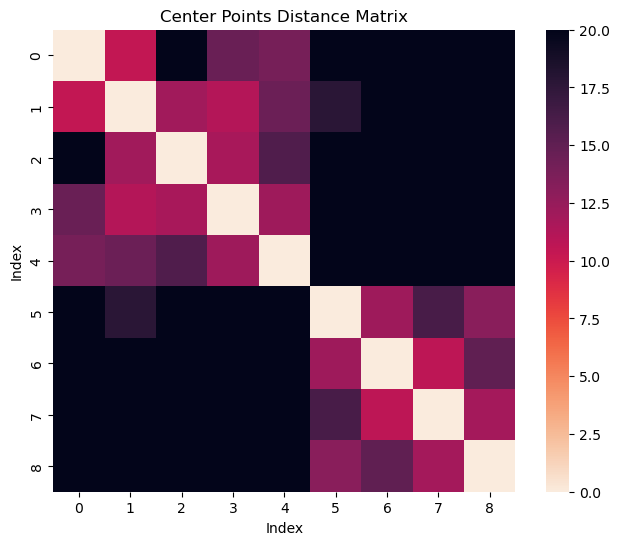

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


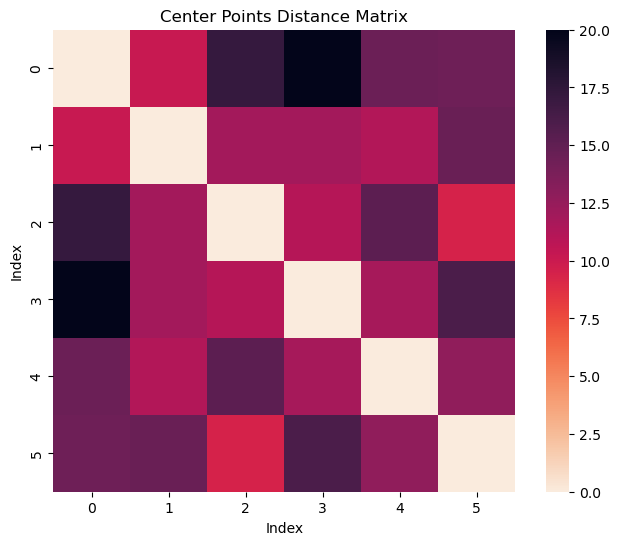

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


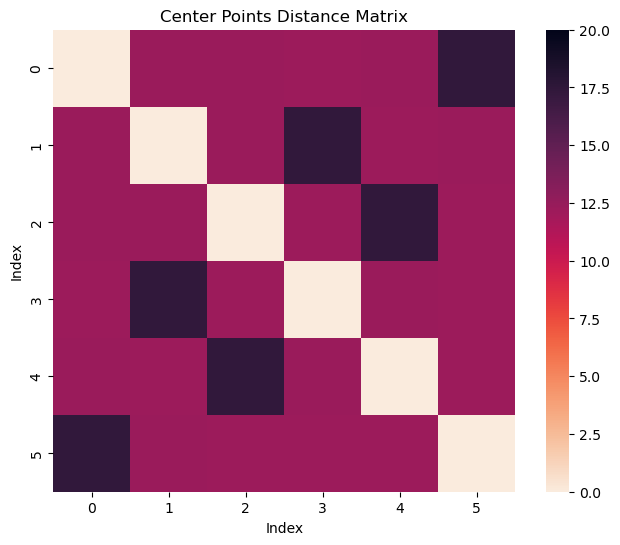

b6iiniin
Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


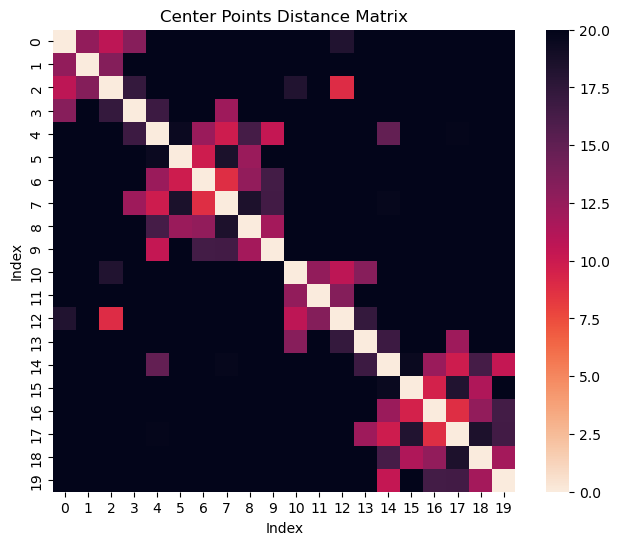

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


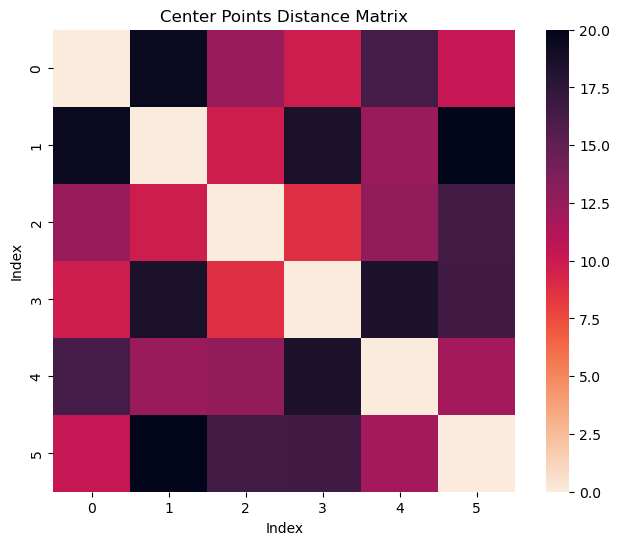

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


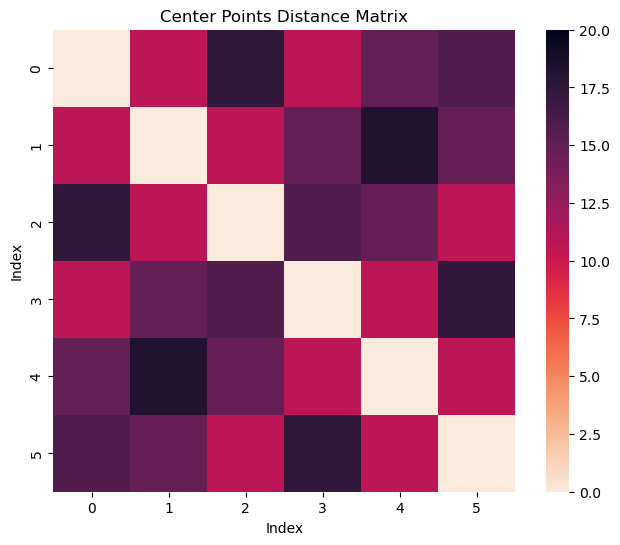

h5n_n
Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


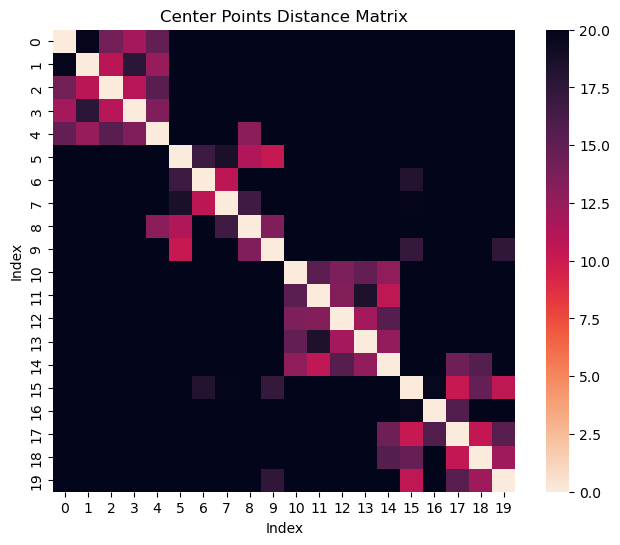

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


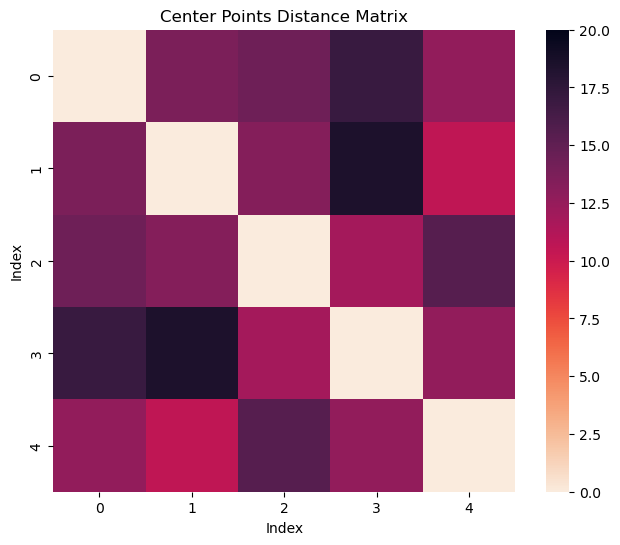

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


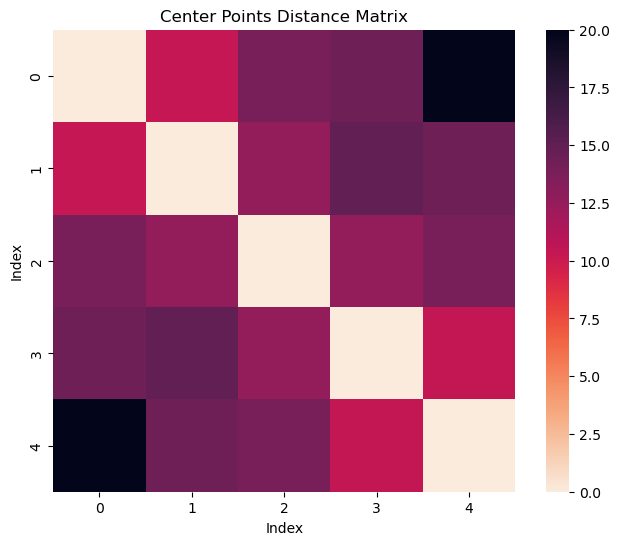

b5ininn
Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


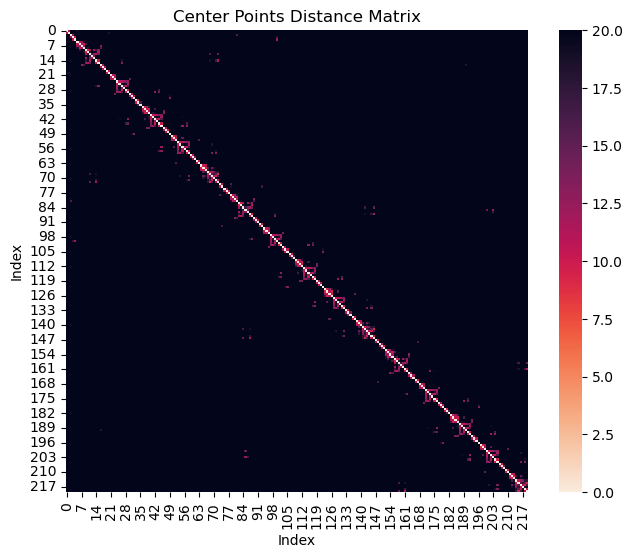

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


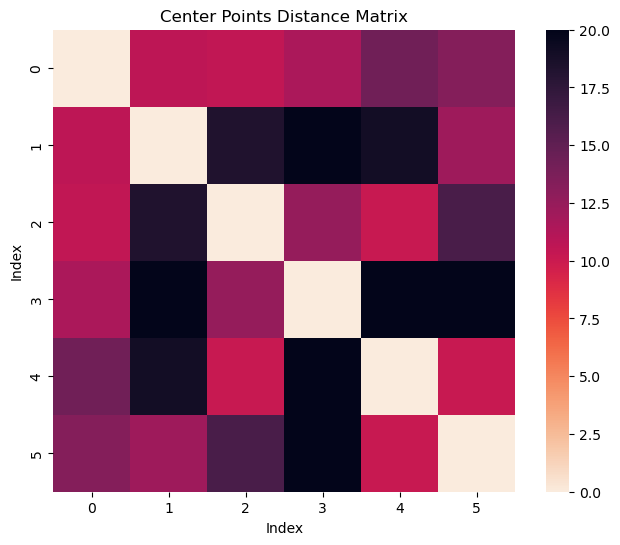

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


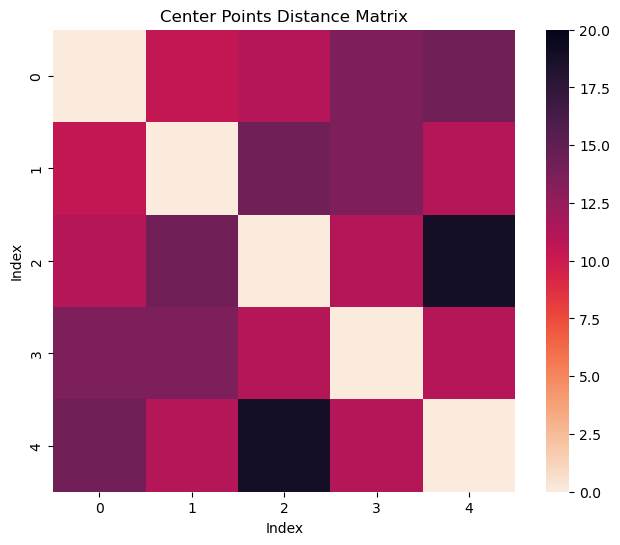

h6n_n_n
Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


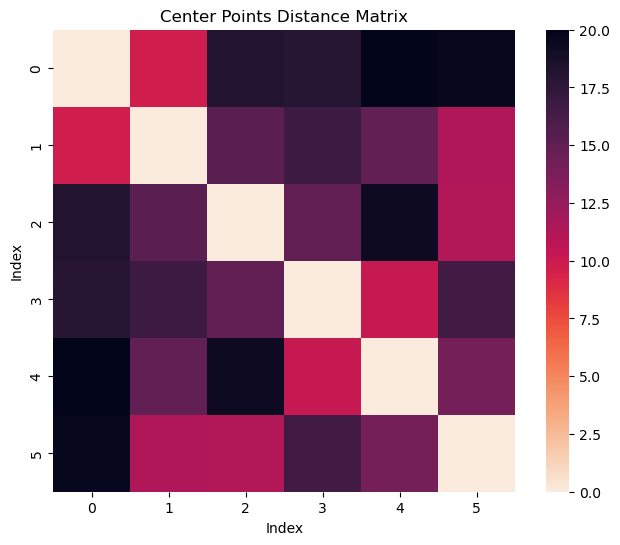

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


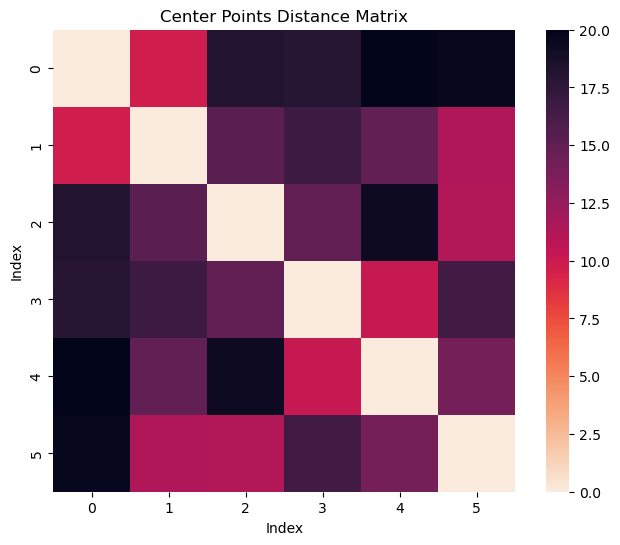

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


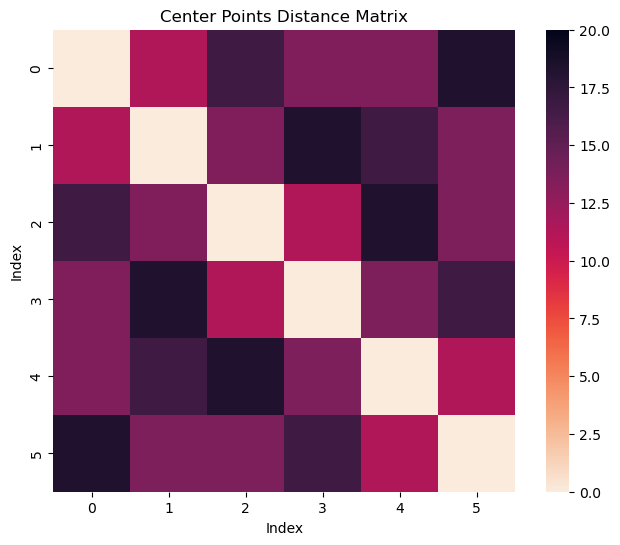

b3iii
Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


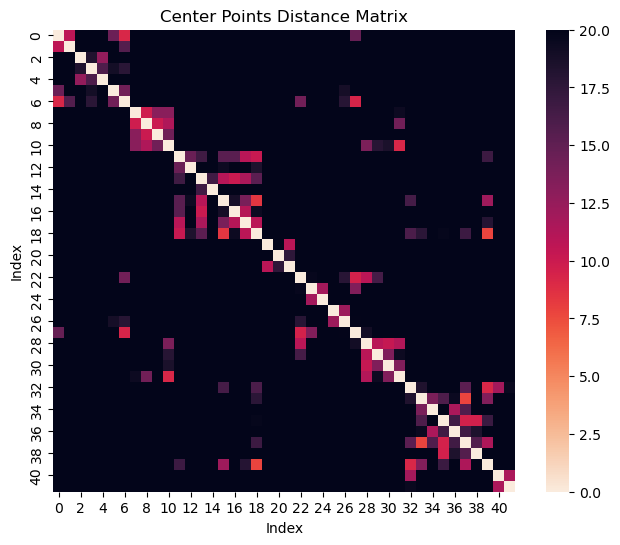

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


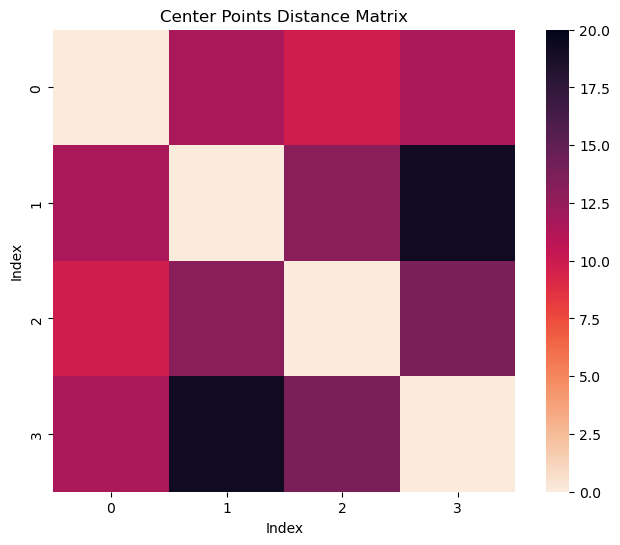

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


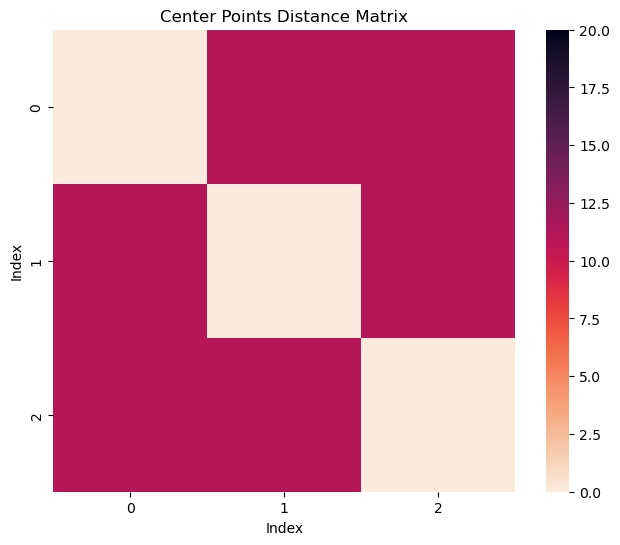

h4i_n
Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


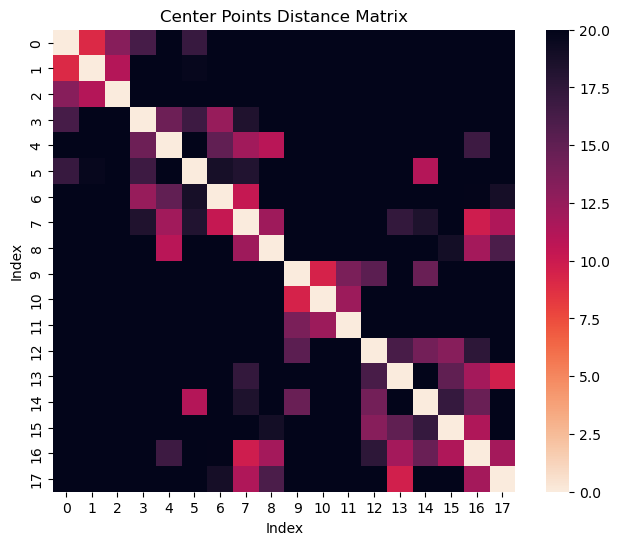

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


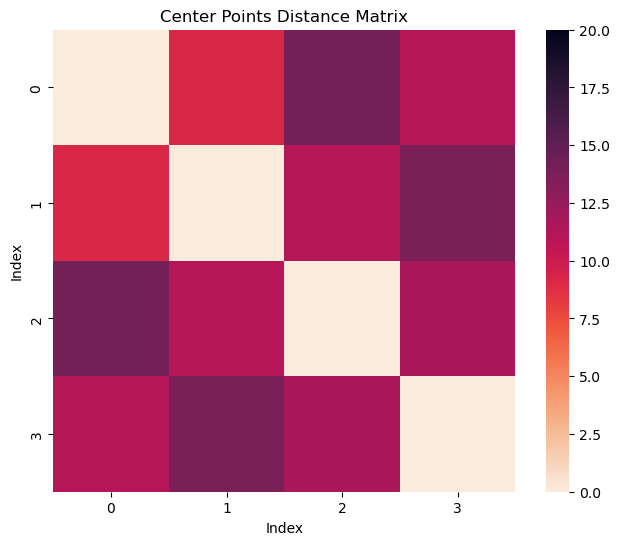

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


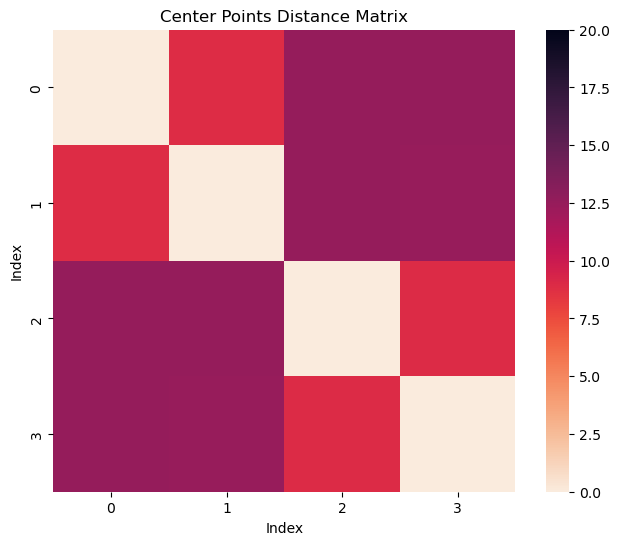

b4nnnnx
Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


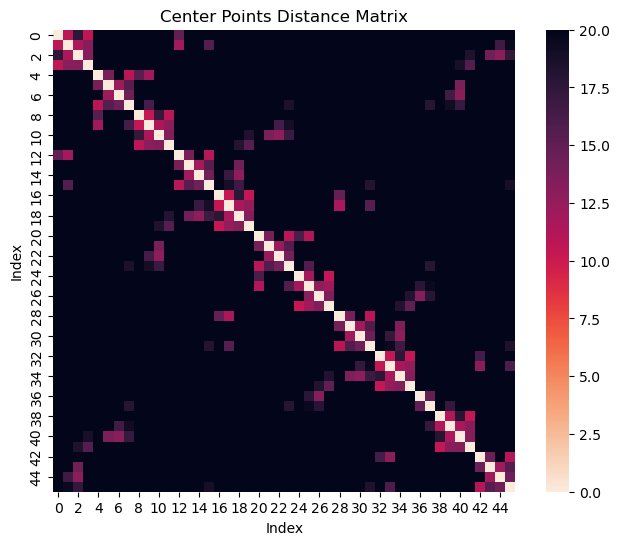

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


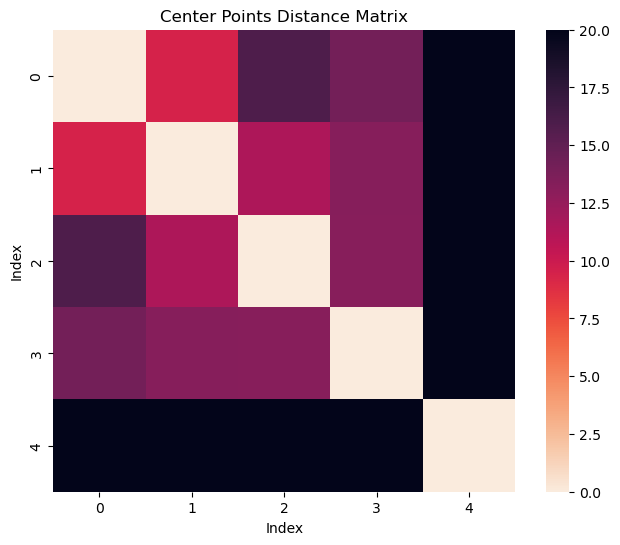

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


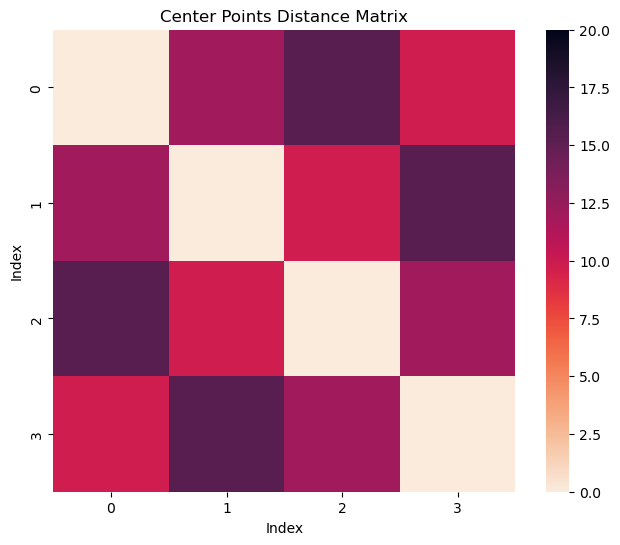

b5iiiin
Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


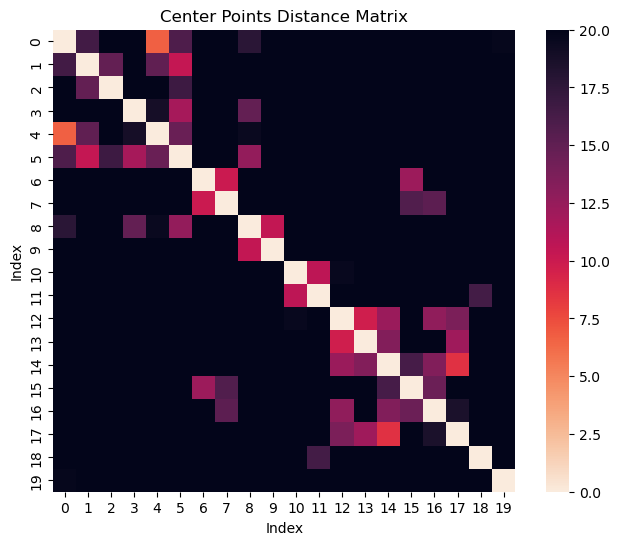

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


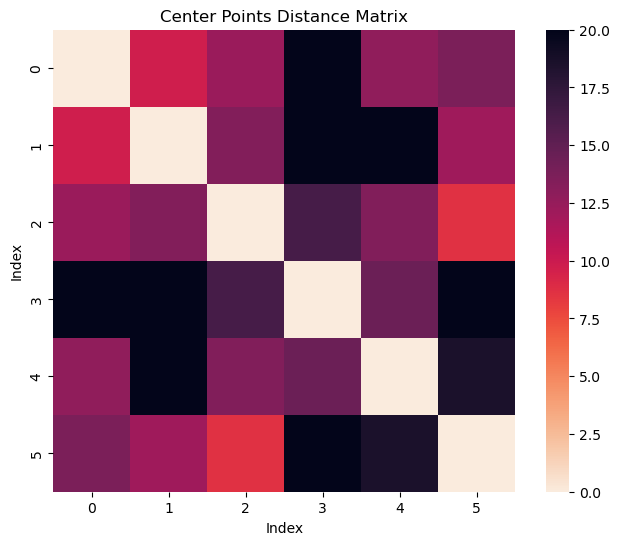

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


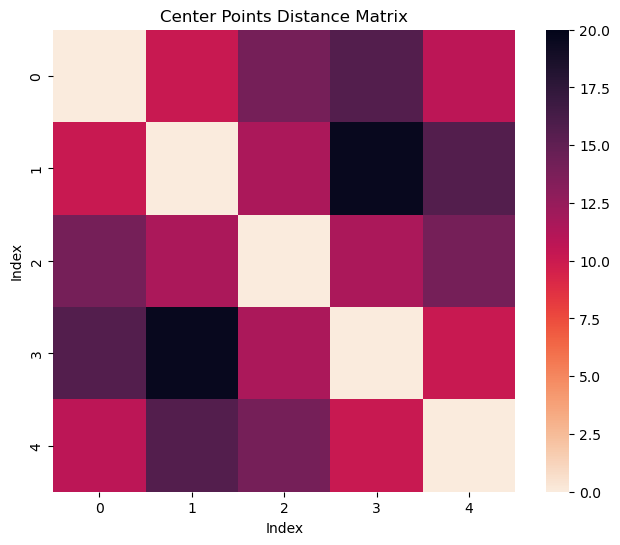

b4iiiix
Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


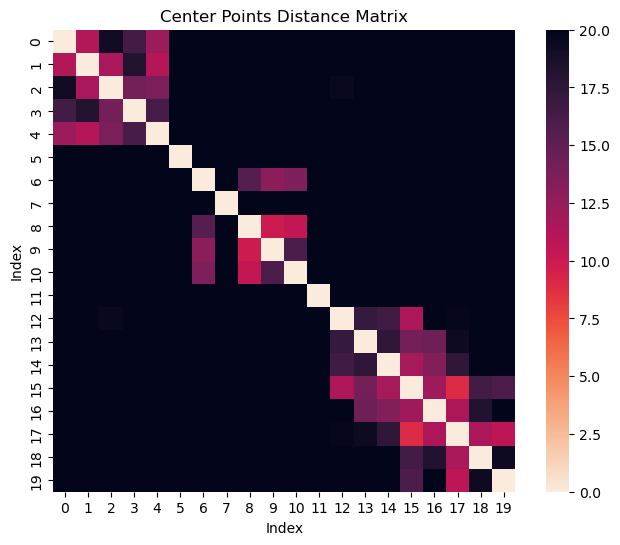

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


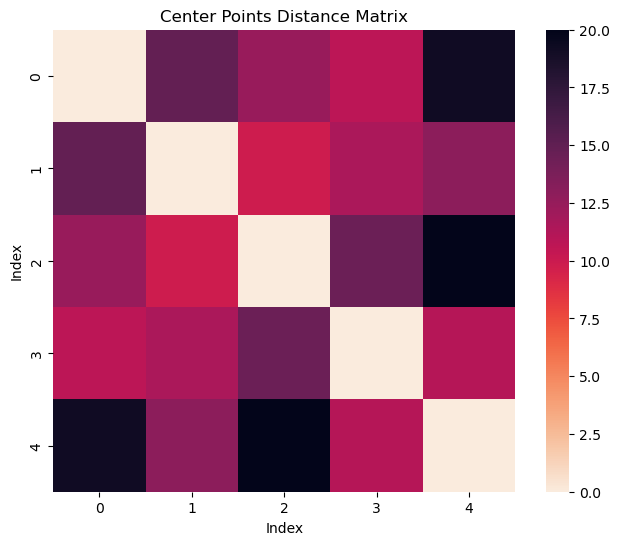

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


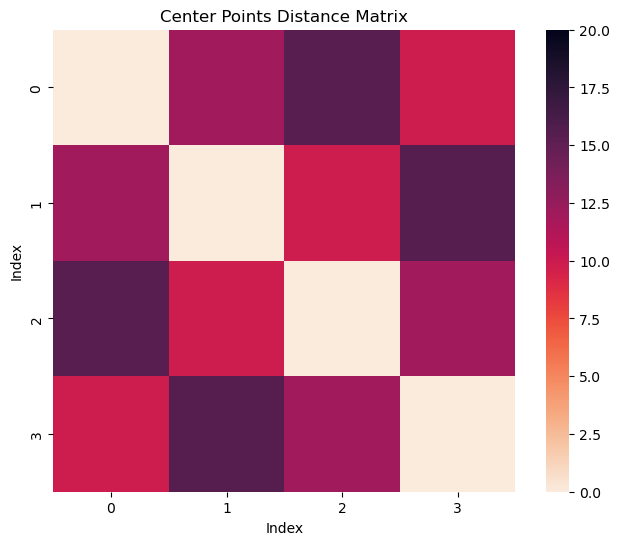

b4iiin
Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


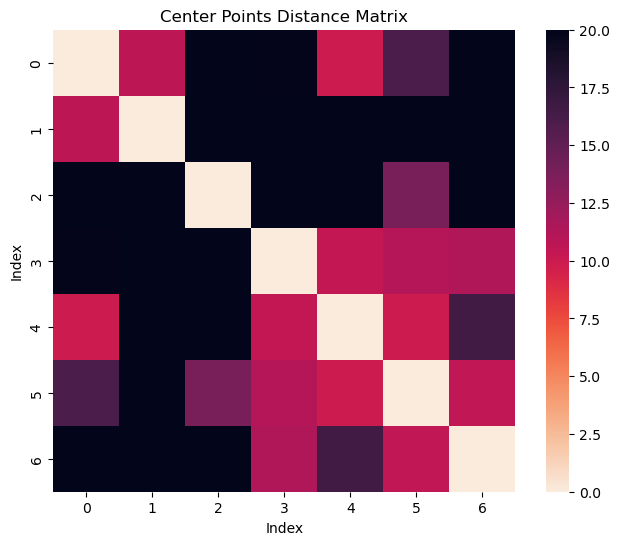

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


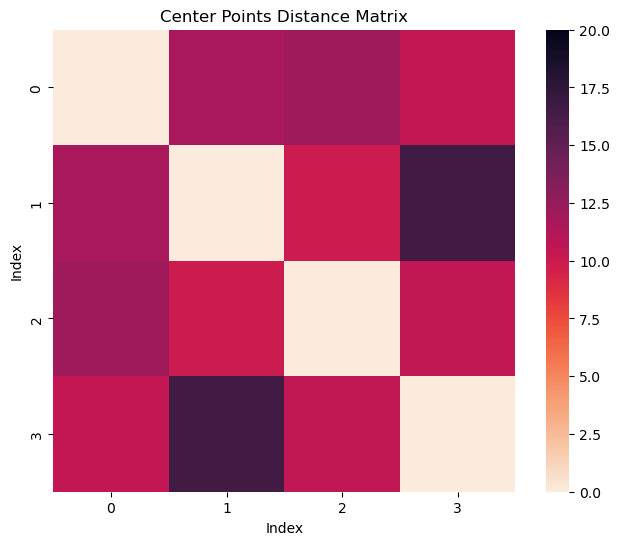

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


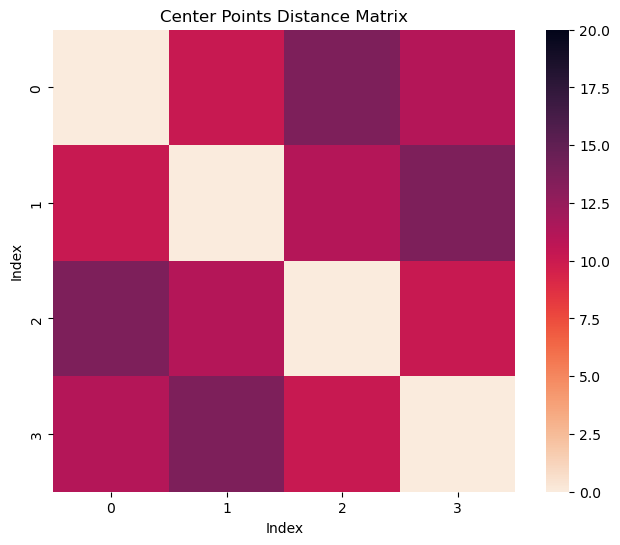

b4nnnny
Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


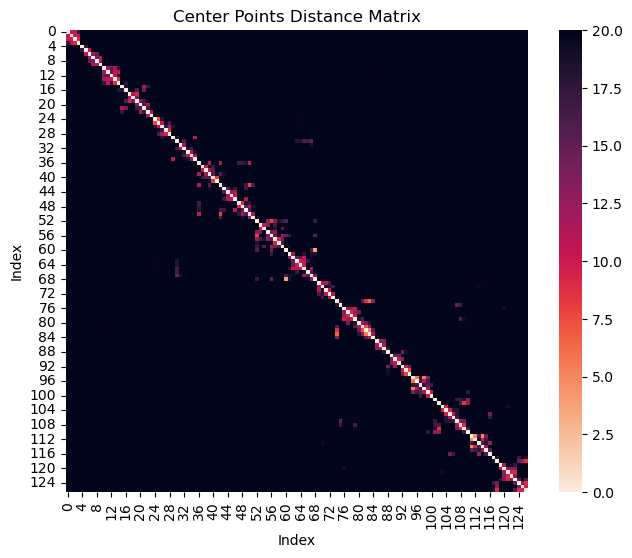

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


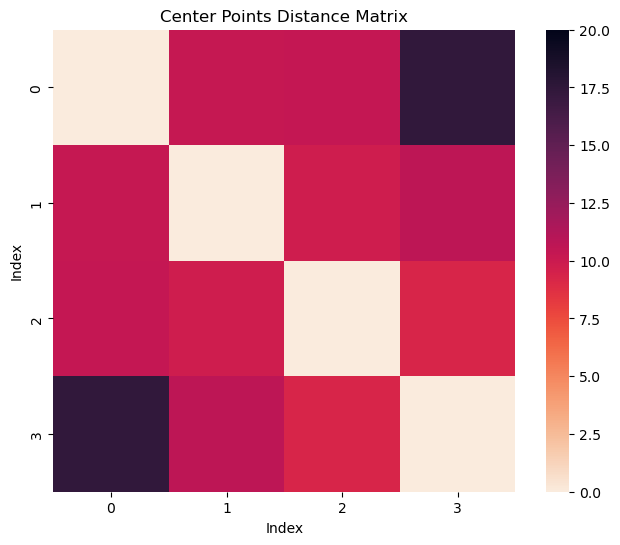

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


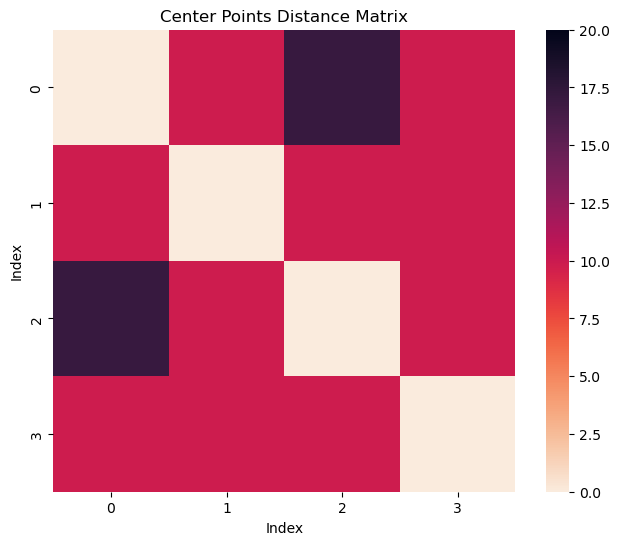

b5innnn
Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


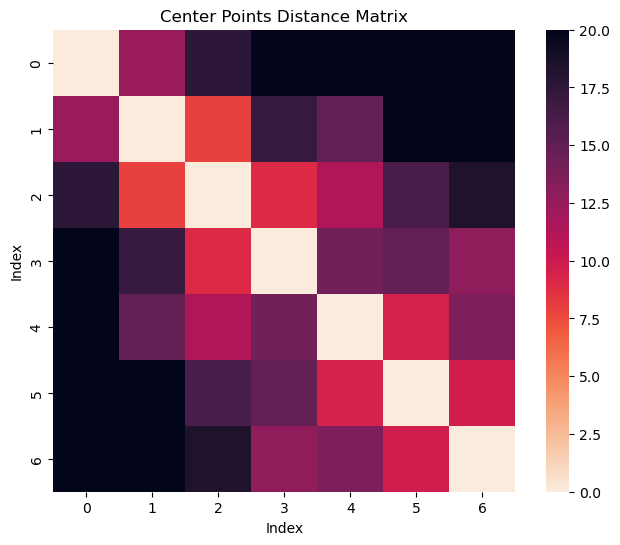

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


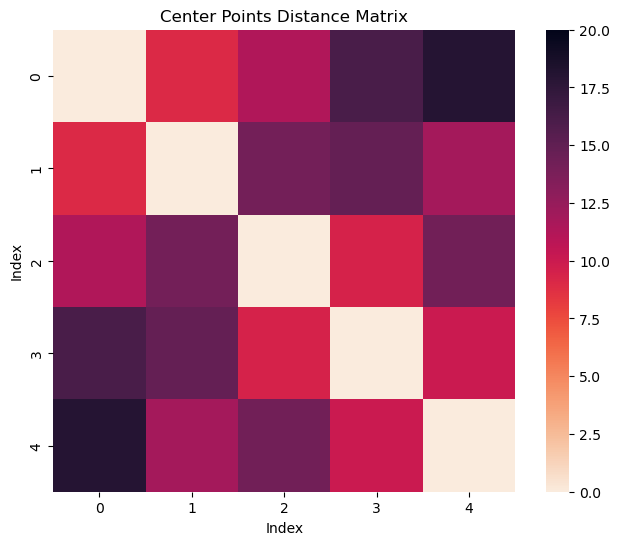

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


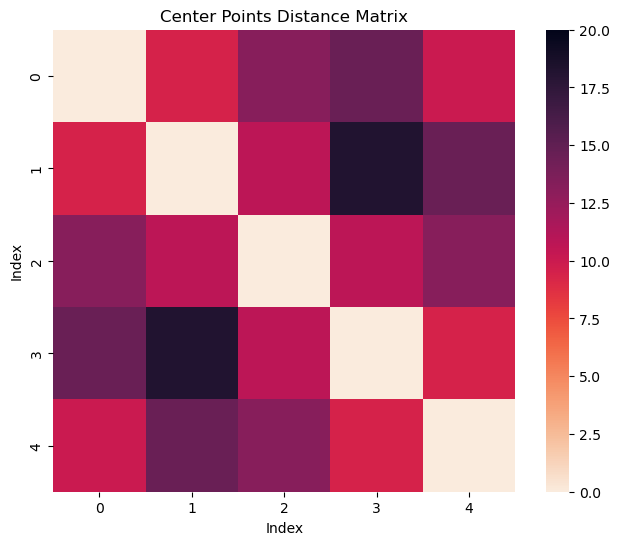

b4iiiiy
Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


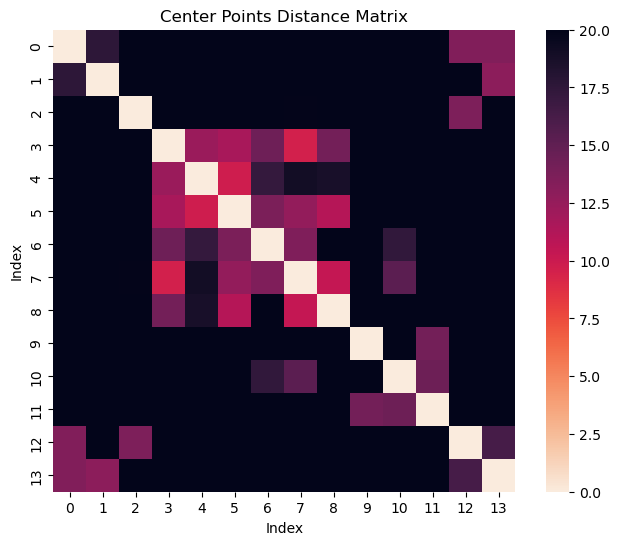

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


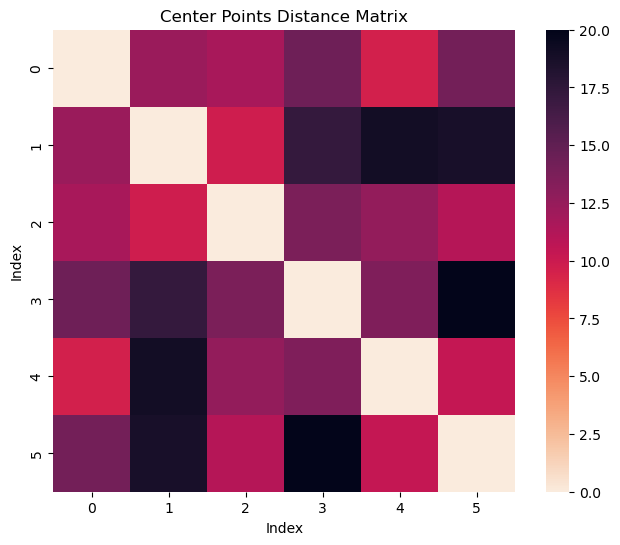

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


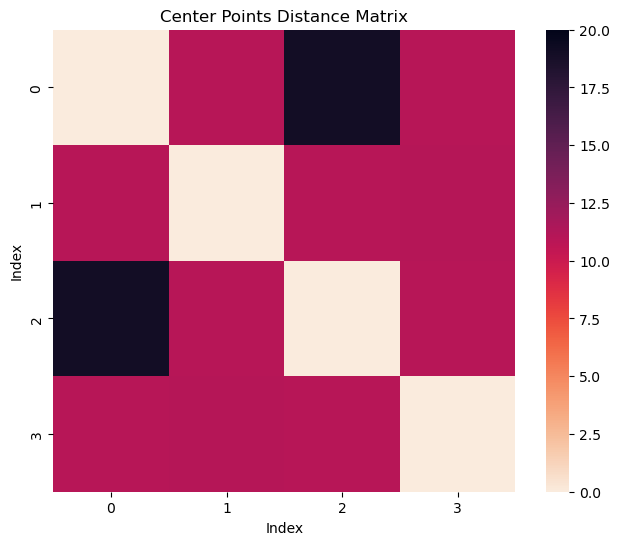

h5i_i
Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


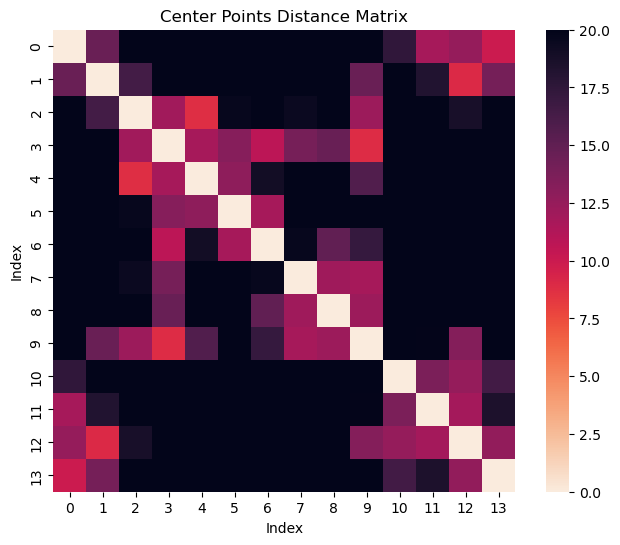

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


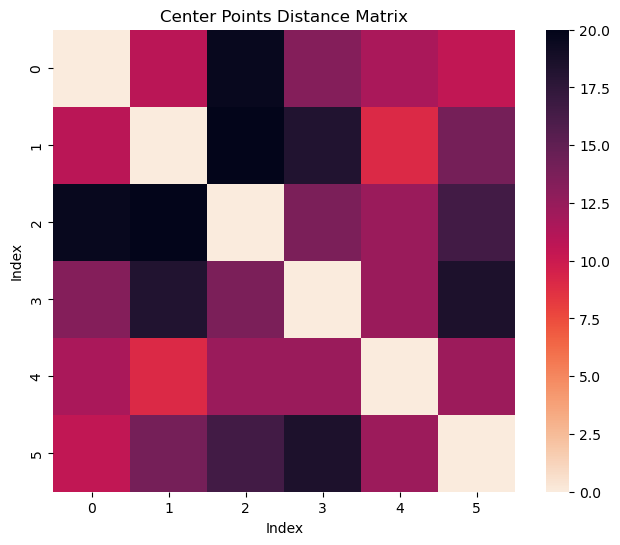

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


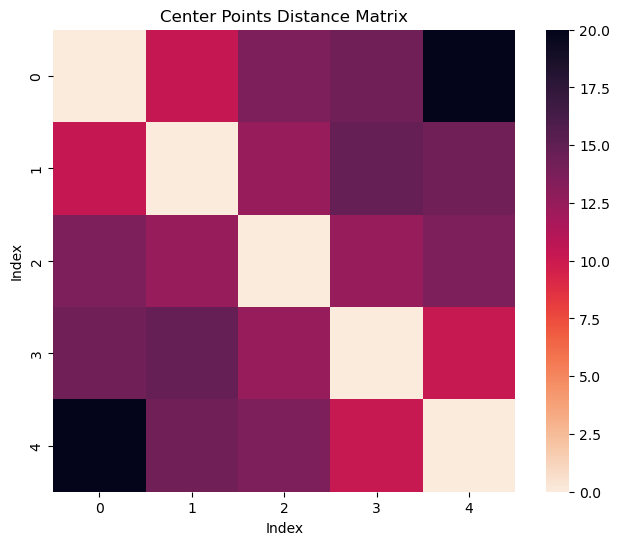

l5niin
Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


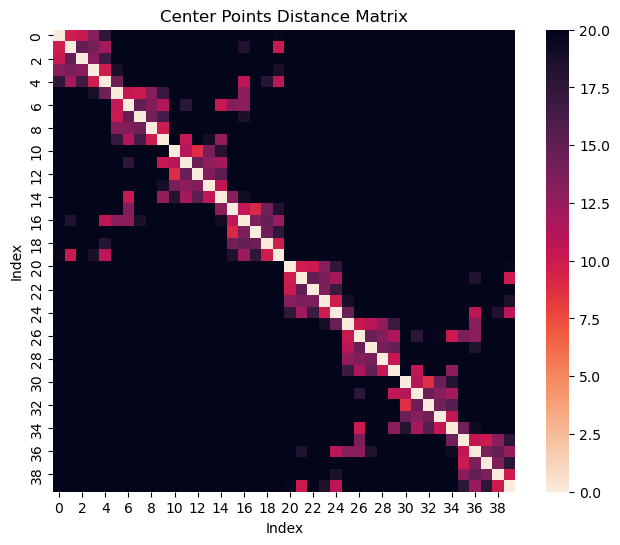

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


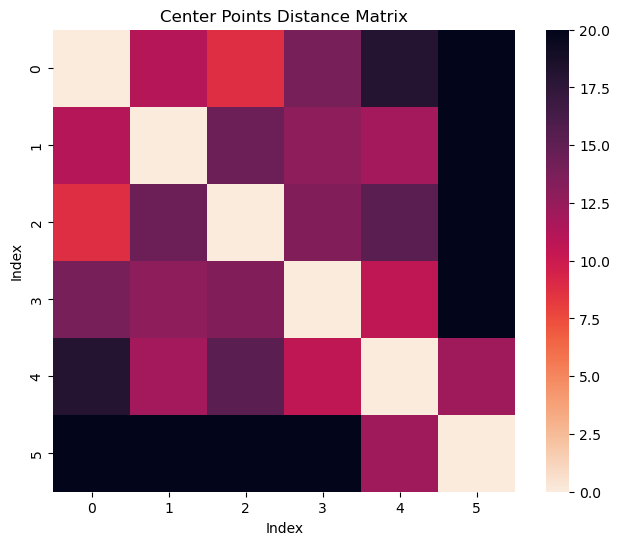

Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


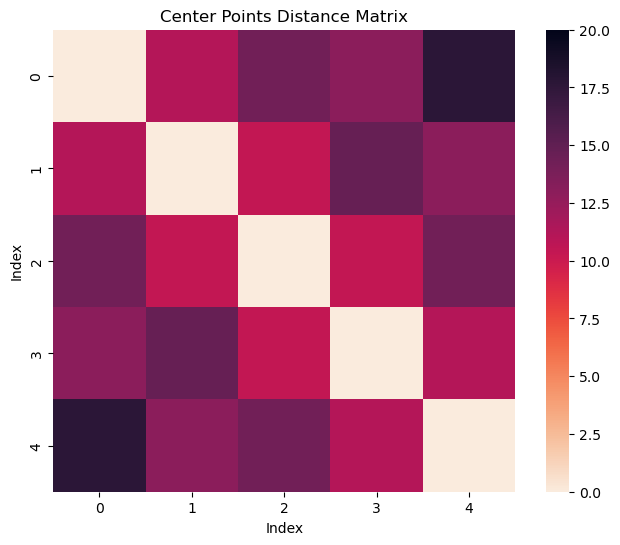

l6innni
Calculating primitives
Getting curvature mask
Getting dssp mask
Error processing  in get_helix_axes: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1132,) + inhomogeneous part.


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1132,) + inhomogeneous part.

In [ ]:




# iterate each folder in /home/tadas/code/deltaProteinSearch/outputs/best_hits_per_orientation
dir = "/home/tadas/code/deltaProteinSearch/outputs/best_hits_per_orientation"
for folder in os.listdir(dir):
    files = os.listdir(os.path.join(dir, folder))
    full = [file for file in files if file.endswith("_full.pdb")]
    domain = [file for file in files if file.endswith("_domain.pdb")]
    remaining = [file for file in files if file not in full and file not in domain]
    print (folder)
    helix_axes = get_helix_axes(os.path.join(dir, folder, full[0]))
    # if len(helix_axes) > 30:
    #     continue
    center_dist_matrix = compute_center_distance_matrix(helix_axes)
    direction_sim_matrix = compute_direction_similarity_matrix(helix_axes)
    plot_heatmap(center_dist_matrix, title="Center Points Distance Matrix", vmin=0, vmax=20)

    helix_axes = get_helix_axes(os.path.join(dir, folder, domain[0]))
    center_dist_matrix = compute_center_distance_matrix(helix_axes)
    direction_sim_matrix = compute_direction_similarity_matrix(helix_axes)
    plot_heatmap(center_dist_matrix, title="Center Points Distance Matrix", vmin=0, vmax=20)

    helix_axes = get_helix_axes(os.path.join(dir, folder, remaining[0]))
    center_dist_matrix = compute_center_distance_matrix(helix_axes)
    direction_sim_matrix = compute_direction_similarity_matrix(helix_axes)
    plot_heatmap(center_dist_matrix, title="Center Points Distance Matrix", vmin=0, vmax=20)
    # in folder find file ends with _full





# helix_axes = get_helix_axes("/home/tadas/code/deltaProteinSearch/outputs/best_hits_per_orientation/l6niiin/l6niiin_4fhr_B01_full.pdb")
# center_dist_matrix = compute_center_distance_matrix(helix_axes)
# direction_sim_matrix = compute_direction_similarity_matrix(helix_axes)
# plot_heatmap(center_dist_matrix, title="Center Points Distance Matrix", vmin=0, vmax=20)

# helix_axes = get_helix_axes("/home/tadas/code/deltaProteinSearch/outputs/best_hits_per_orientation/l6niiin/l6niiin_4fhr_B01_domain.pdb")
# center_dist_matrix = compute_center_distance_matrix(helix_axes)
# direction_sim_matrix = compute_direction_similarity_matrix(helix_axes)
# plot_heatmap(center_dist_matrix, title="Center Points Distance Matrix", vmin=0, vmax=20)
# # # Visualize the direction similarity (dot product) matrix as a heatmap
# # plot_heatmap(direction_sim_matrix, title="Direction Similarity (Dot Product) Matrix")



Calculating primitives
Getting curvature mask
Getting dssp mask
Getting primitives contigs
Primitive contigs to helix axes


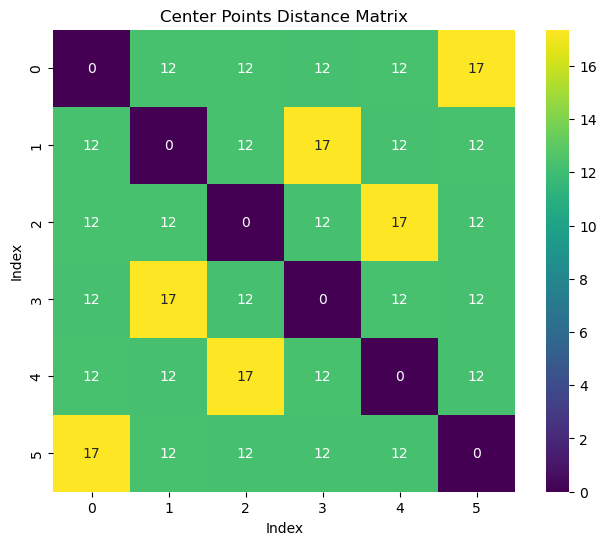

720


Saved GIF with 720 frames to 'center_matrix_rearrangements.gif'.


In [60]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import imageio
import io

def compute_center_distance_matrix(axes):
    """
    Computes the pairwise Euclidean distance matrix for the center points.
    This is rotation invariant.
    """
    centers = np.array([axis['center'] for axis in axes])
    diff = centers[:, np.newaxis, :] - centers[np.newaxis, :, :]
    dist_matrix = np.linalg.norm(diff, axis=-1)
    return dist_matrix

def compute_direction_similarity_matrix(axes):
    """
    Computes the pairwise dot product matrix for the normalized direction vectors.
    """
    directions = np.array([axis['direction'] for axis in axes])
    norms = np.linalg.norm(directions, axis=1, keepdims=True)
    normalized_directions = directions / norms
    sim_matrix = np.dot(normalized_directions, normalized_directions.T)
    return sim_matrix

def plot_heatmap(matrix, title="Heatmap", xlabel="Index", ylabel="Index"):
    """
    Plots a heatmap of the given matrix using Seaborn.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, cmap="viridis", square=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def create_heatmap_gif(matrix, title="Heatmap", xlabel="Index", ylabel="Index", output_file="heatmap_rearrangements.gif", duration=0.1):
    """
    Creates a GIF that displays heatmaps for all possible rearrangements (permutations)
    of the matrix rows/columns.
    
    Parameters:
      matrix: 2D numpy array (square matrix) to be rearranged.
      title: Title string for the heatmap.
      xlabel, ylabel: Axis labels.
      output_file: Name of the output gif file.
      duration: Duration (in seconds) for each frame in the gif.
    """
    n = matrix.shape[0]
    frames = []
    
    # Generate all permutations of indices [0, 1, ..., n-1]
    perms = list(itertools.permutations(range(n)))
    print(len(perms))
    for perm in perms:
        perm = list(perm)
        rearranged = matrix[perm][:, perm]
        
        # Create the plot and capture it in a BytesIO buffer
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(rearranged, annot=True, cmap="viridis", square=True, ax=ax)
        ax.set_title(f"{title}\nPermutation: {perm}")
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight')
        plt.close(fig)
        buf.seek(0)
        frame = imageio.imread(buf)
        frames.append(frame)
    
    imageio.mimsave(output_file, frames, duration=duration)
    print(f"Saved GIF with {len(frames)} frames to '{output_file}'.")


helix_axes = get_helix_axes("/home/tadas/code/deltaProteinSearch/outputs/best_hits_per_orientation/s6/s6.pdb")

# Compute the center distance matrix
center_dist_matrix = compute_center_distance_matrix(helix_axes)

# Plot the original heatmap
plot_heatmap(center_dist_matrix, title="Center Points Distance Matrix")

# Create and save a GIF showing all rearrangements
create_heatmap_gif(center_dist_matrix, title="Center Points Distance Matrix", output_file="center_matrix_rearrangements.gif", duration=0.1)


/tmp/ipykernel_1952124/108902017.py:38: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




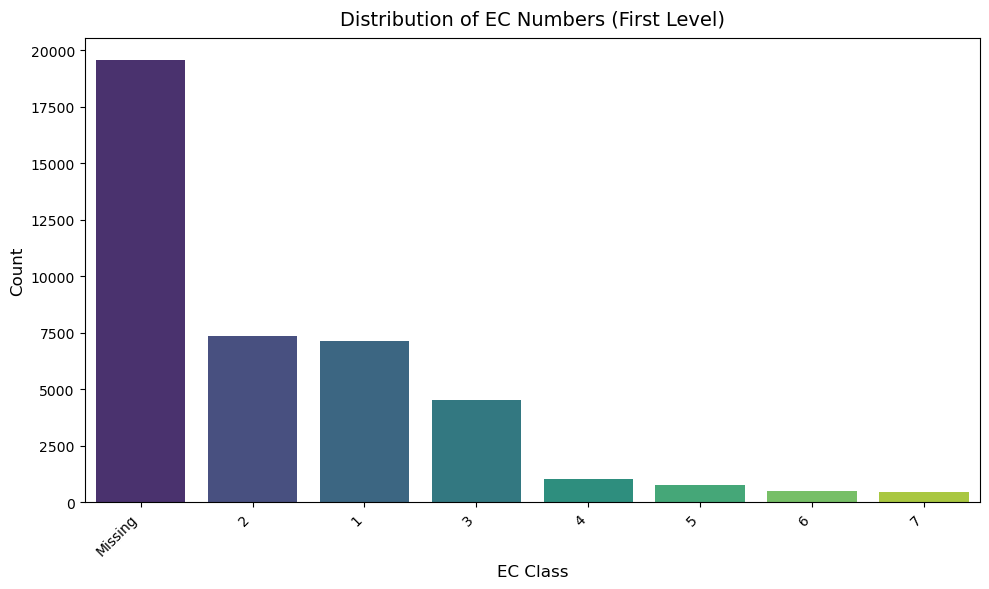

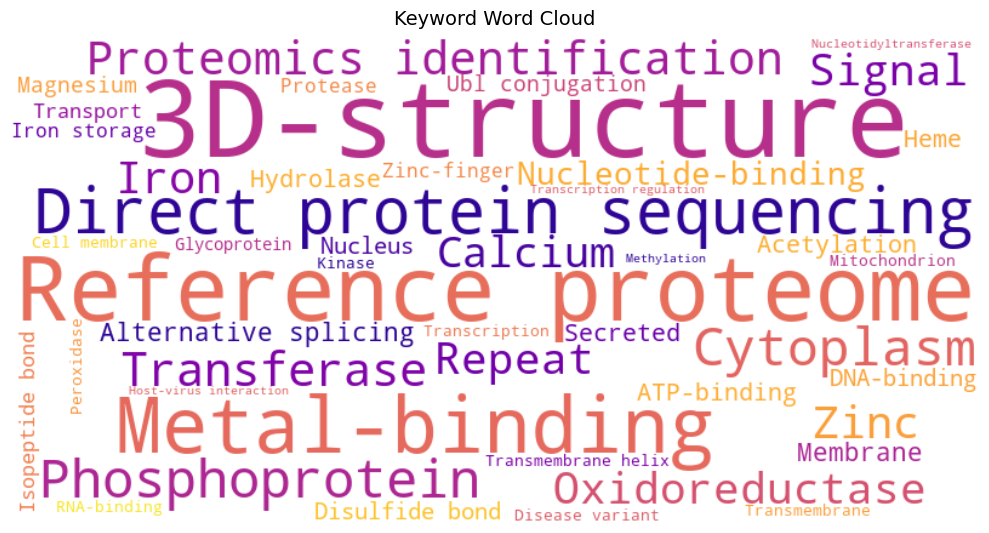

/tmp/ipykernel_1952124/108902017.py:64: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




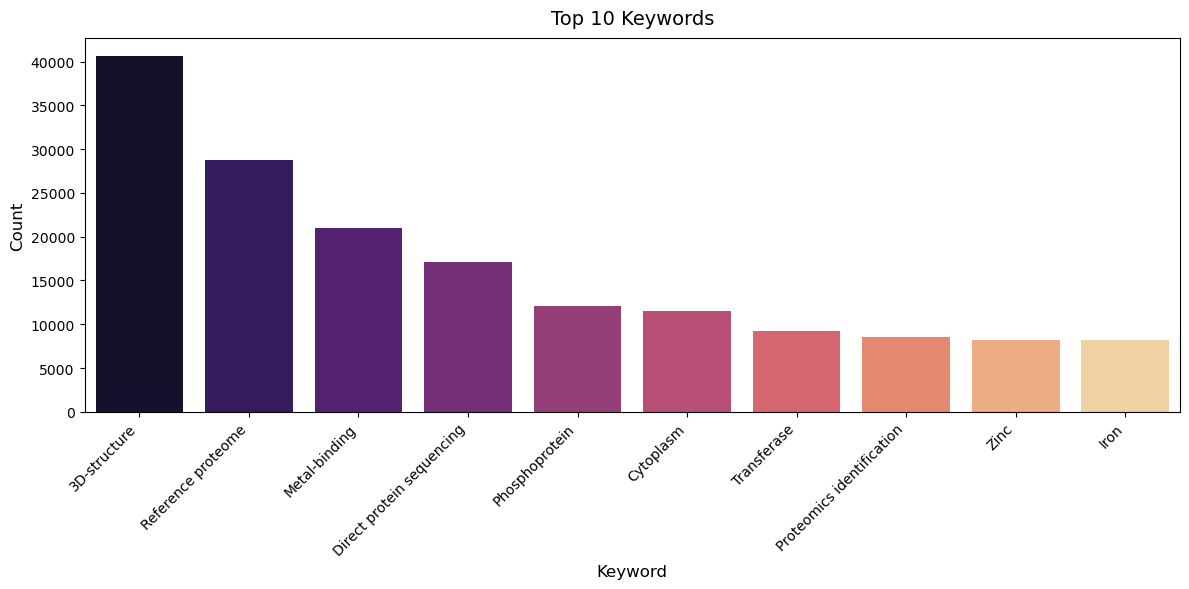

In [46]:
df = pd.read_csv("/home/tadas/code/deltaProteinSearch/outputs/pdb_with_uniprot_details_async.csv")


# Preprocess CATH codes into hierarchical levels
df['cath_levels'] = df['cath'].str.split('.')
df[['Class', 'Architecture', 'Topology', 'Superfamily']] = pd.DataFrame(df['cath_levels'].tolist(), index=df.index)

# Prepare data for sunburst
cath_hierarchy = df.groupby(['Class', 'Architecture', 'Topology', 'Superfamily']).size().reset_index(name='Count')

# Plot with Plotly
fig = px.sunburst(
    cath_hierarchy,
    path=['Class', 'Architecture', 'Topology', 'Superfamily'],
    values='Count',
    title='CATH Classification Hierarchy',
    color='Class',
    color_discrete_sequence=px.colors.qualitative.Set2,
    width=800,
    height=800
)
fig.update_layout(
    title_font_size=16,
    margin=dict(t=50, l=25, r=25, b=25)
)
fig.show()


# Preprocess EC numbers: Extract first level and handle missing
df['ec_first'] = df['ec_number'].fillna('Missing').apply(lambda x: x.split('.')[0] if x != 'Missing' else 'Missing')

# Count occurrences
ec_counts = df['ec_first'].dropna().value_counts().reset_index()
ec_counts.columns = ['EC_Class', 'Count']

# Plot with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=ec_counts, x='EC_Class', y='Count', palette='viridis')
plt.title('Distribution of EC Numbers (First Level)', fontsize=14, pad=10)
plt.xlabel('EC Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Split keywords and count frequencies
keywords_list = df['keywords'].str.split('; ').explode().str.strip()
keyword_counts = Counter(keywords_list)

# Word Cloud
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma', min_font_size=10).generate_from_frequencies(keyword_counts)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keyword Word Cloud', fontsize=14, pad=10)
plt.tight_layout()
plt.show()

# Top-N Bar Chart
top_n = 10
top_keywords = pd.DataFrame(keyword_counts.most_common(top_n), columns=['Keyword', 'Count'])

plt.figure(figsize=(12, 6))
sns.barplot(data=top_keywords, x='Keyword', y='Count', palette='magma')
plt.title(f'Top {top_n} Keywords', fontsize=14, pad=10)
plt.xlabel('Keyword', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [43]:
df = pd.read_csv("/home/tadas/code/deltaProteinSearch/outputs/pdb_with_uniprot_details_async.csv")
df.uniprot_id.isna().sum()

621

In [34]:
df[["ec_number","keywords","cath","orientation_code","pdb_code","domain"]].to_csv("annotated.csv",index=False)

In [35]:
df[["ec_number","keywords","cath","orientation_code","pdb_code","domain"]]

ec_number                                           keywords  \
0       5.6.2.4  3D-structure; ATP-binding; DNA replication; DN...   
1       2.7.1.6  3D-structure; ATP-binding; Carbohydrate metabo...   
2           NaN                                       3D-structure   
3           NaN  3D-structure; Cytoplasm; DNA-binding; Iron; Me...   
4           NaN  3D-structure; Cytoplasm; DNA-binding; Iron; Me...   
...         ...                                                ...   
41328   5.6.2.4  3D-structure; ATP-binding; Helicase; Hydrolase...   
41329       NaN  3D-structure; Activation of host caspases by v...   
41330       NaN  3D-structure; Alternative splicing; Calcium; C...   
41331       NaN      3D-structure; Reference proteome; Transferase   
41332       NaN  3D-structure; Activation of host autophagy by ...   

               cath orientation_code pdb_code domain  
0       1.10.10.160            b3nnn     1uaa    A02  
1       3.30.230.10          b4nnnny     1s4e    E01  
2        1.10.10.10            b3nnn     2ns0    A00  
3        1.10.10.10            b3nnn     5nbc    B01  
4        1.10.10.10            b3nnn     5nhk    B01  
...             ...              ...      ...    ...  
41328   1.10.10.160          b5innnn     4c30    A02  
41329   1.10.150.90           b4iiin     1hiw    A00  
41330   1.10.246.10           b4iiin     2vuf    B05  
41331  1.20.1050.10           b4inin     3tou    B02  
41332  1.10.1840.10          b4iiiix     3szn    A03  

[41333 rows x 6 columns]

In [61]:

cath_domains=get_cath_domains()
print(len(cath_domains))

536613


In [59]:
df = pd.read_pickle("/home/tadas/code/deltaProteinSearch/outputs/cath_deltaprots.pkl")

In [60]:
print(len(df["filename"].unique()))
df["pdb_code"] = df["filename"].apply(lambda x: x.split("_")[0])
print(len(df["pdb_code"].unique()))

456701
132980


In [51]:
from deltaprot_search import locate_pdb


df = pd.read_csv(
    "/home/tadas/code/deltaProteinSearch/outputs/pdb_with_uniprot_details_async.csv"
)

df["path_to_pdb_file"] = df["pdb_code"].apply(lambda x: locate_pdb(x, biounit=False))

In [ ]:
df.orientation_code

0          b3nnn
1        b4nnnny
2          b3nnn
3          b3nnn
4          b3nnn
          ...   
41328    b5innnn
41329     b4iiin
41330     b4iiin
41331     b4inin
41332    b4iiiix
Name: orientation_code, Length: 41333, dtype: object

In [55]:
cath_domains = get_cath_domains()
cath_domains

pdb_code domain   version          cath     chain_info_str  C   A    T  \
0          101m    A00    v4_2_0   1.10.490.10             A0-153  1  10  490   
1          102l    A00    v4_2_0   1.10.530.40             A1-162  1  10  530   
2          102m    A00    v4_2_0   1.10.490.10             A0-153  1  10  490   
3          103l    A00    v4_2_0   1.10.530.40             A1-162  1  10  530   
4          103m    A00    v4_2_0   1.10.490.10             A0-153  1  10  490   
...         ...    ...       ...           ...                ... ..  ..  ...   
536608     7cdv    B02  putative  3.40.50.2300  B180-309/B342-349  3  40   50   
536609     7cdx    A01  putative  3.40.50.2300   A75-179/A310-341  3  40   50   
536610     7cdx    A02  putative  3.40.50.2300  A180-309/A342-346  3  40   50   
536611     7cdx    B01  putative  3.40.50.2300   B77-179/B310-341  3  40   50   
536612     7cdx    B02  putative  3.40.50.2300  B180-309/B342-348  3  40   50   

           H  
0         10  
1         40  
2         10  
3         40  
4         10  
...      ...  
536608  2300  
536609  2300  
536610  2300  
536611  2300  
536612  2300  

[536613 rows x 9 columns]

In [53]:
from dp_utils.functions import copy_files_to_local_directory


copy_files_to_local_directory(df["path_to_pdb_file"].tolist(),"/mnt/scratch/datasets/best_deltaprots_1")

In [43]:


cath_domains=get_cath_domains(C=1)

# Load subset of data (first 1
df = pd.read_pickle(
    "/home/tadas/code/deltaProteinSearch/outputs/filtered_cath_deltaprots.pkl"
)
df = df[df["orientation_code"].notna()]
df.sort_values("total_cost", inplace=True)
df = df[df["total_cost"] < 1.5]
df = df[(df["total_scale"] > 9.0) & (df["total_scale"] < 13.0)]
df["pdb_code"] = df["filename"].apply(lambda x: x.split("_")[0])
df["domain"] = df["filename"].apply(lambda x: x.split("_")[1])
# only keep inner s
df = pd.merge(df, cath_domains, how="left", on=["domain", "pdb_code"])
# save df 
df[["pdb_code", "domain", "chain_info_str"]].to_csv("/home/tadas/code/deltaProteinSearch/outputs/natural_dps_up_to_1_5cost.csv")
# merge wtih cath_domains df on domain and pdb_code

display(df)


filename                                         helix_axes  \
0      1uaa_A02  [{'center': [22.631725809665184, 23.2975585854...   
1      1s4e_E01  [{'center': [153.89329981522843, 52.5184096965...   
2      2ns0_A00  [{'center': [34.19001890873589, 44.48195997172...   
3      5nbc_B01  [{'center': [20.09705617663946, 15.92510207700...   
4      5nhk_B01  [{'center': [19.666637344538973, 15.4267053945...   
...         ...                                                ...   
41328  4c30_A02  [{'center': [13.523276981576576, -3.9765480718...   
41329  1hiw_A00  [{'center': [14.419315784569294, 62.9681183812...   
41330  2vuf_B05  [{'center': [61.68847740272759, 27.12478488857...   
41331  3tou_B02  [{'center': [16.951469673053445, 23.8066399922...   
41332  3szn_A03  [{'center': [12.95454480533361, 12.53821729913...   

      orientation_code                                    rotation_matrix  \
0                b3nnn  [[0.3951950923289687, -0.827811126253401, -0.3...   
1              b4nnnny  [[-0.7707152262772573, 0.12280784014065045, 0....   
2                b3nnn  [[0.42172135916834896, -0.8371916043807216, -0...   
3                b3nnn  [[-0.9627951716635197, -0.014157018493443928, ...   
4                b3nnn  [[-0.9631230218583395, 0.005491230188801727, -...   
...                ...                                                ...   
41328          b5innnn  [[0.22630491137603068, -0.8278186154542152, 0....   
41329           b4iiin  [[-0.766250830905491, -0.5618510855957133, 0.3...   
41330           b4iiin  [[0.5243518497454027, -0.30369978349512217, 0....   
41331           b4inin  [[-0.41896595739163545, 0.9055088251574541, -0...   
41332          b4iiiix  [[0.174593558478743, -0.11240917230879661, -0....   

       primary_scale  fine_scale  total_scale  \
0          15.434350    0.816186    12.597304   
1          11.078881    0.983041    10.890992   
2          12.032532    0.949776    11.428206   
3          13.771997    0.919892    12.668745   
4          13.681075    0.926779    12.679338   
...              ...         ...          ...   
41328      13.570849    0.874225    11.863979   
41329      14.949696    0.740817    11.074991   
41330      13.321616    0.875764    11.666595   
41331      13.069426    0.909765    11.890105   
41332      14.503467    0.826695    11.989941   

                                      translation_matrix  sliding_rmsd  \
0      [15.990576024475486, 22.16668290520454, 94.485...      0.238365   
1      [147.23156255696054, 45.31993216565196, 80.103...      0.407333   
2      [30.08247654261523, 40.01714125012875, 31.8302...      0.268530   
3      [18.180061818792495, 13.717418639132802, 29.01...      0.205504   
4      [17.973537315988516, 13.599535005067358, 29.09...      0.264929   
...                                                  ...           ...   
41328  [10.782422115944152, -11.87458944560063, -10.4...      3.123169   
41329  [13.38632849975994, 57.205317661558894, 49.252...      1.025613   
41330  [47.34671741959135, 27.044809876735158, 70.649...      2.843464   
41331  [10.339651706758575, 27.39191231712369, 29.291...      2.175063   
41332  [15.02623466797425, 16.651453951897917, -6.036...      4.025470   

           rmsd  ...  total_cost pdb_code domain   version          cath  \
0      2.389966  ...    0.151379     1uaa    A02    v4_2_0   1.10.10.160   
1      2.096638  ...    0.162285     1s4e    E01       NaN           NaN   
2      2.218957  ...    0.177365     2ns0    A00    v4_2_0    1.10.10.10   
3      2.320962  ...    0.184855     5nbc    B01  putative    1.10.10.10   
4      2.261592  ...    0.185310     5nhk    B01  putative    1.10.10.10   
...         ...  ...         ...      ...    ...       ...           ...   
41328  4.953914  ...    1.499939     4c30    A02    v4_2_0   1.10.10.160   
41329  2.361155  ...    1.499949     1hiw    A00    v4_2_0   1.10.150.90   
41330  3.827799  ...    1.499975     2vuf    B05    v4_2_0   1.10.246.10   
413

In [24]:
len(df)

41333

In [25]:
df

filename                                         helix_axes  \
0      1uaa_A02  [{'center': [22.631725809665184, 23.2975585854...   
1      1s4e_E01  [{'center': [153.89329981522843, 52.5184096965...   
2      2ns0_A00  [{'center': [34.19001890873589, 44.48195997172...   
3      5nbc_B01  [{'center': [20.09705617663946, 15.92510207700...   
4      5nhk_B01  [{'center': [19.666637344538973, 15.4267053945...   
...         ...                                                ...   
41328  4c30_A02  [{'center': [13.523276981576576, -3.9765480718...   
41329  1hiw_A00  [{'center': [14.419315784569294, 62.9681183812...   
41330  2vuf_B05  [{'center': [61.68847740272759, 27.12478488857...   
41331  3tou_B02  [{'center': [16.951469673053445, 23.8066399922...   
41332  3szn_A03  [{'center': [12.95454480533361, 12.53821729913...   

      orientation_code                                    rotation_matrix  \
0                b3nnn  [[0.3951950923289687, -0.827811126253401, -0.3...   
1              b4nnnny  [[-0.7707152262772573, 0.12280784014065045, 0....   
2                b3nnn  [[0.42172135916834896, -0.8371916043807216, -0...   
3                b3nnn  [[-0.9627951716635197, -0.014157018493443928, ...   
4                b3nnn  [[-0.9631230218583395, 0.005491230188801727, -...   
...                ...                                                ...   
41328          b5innnn  [[0.22630491137603068, -0.8278186154542152, 0....   
41329           b4iiin  [[-0.766250830905491, -0.5618510855957133, 0.3...   
41330           b4iiin  [[0.5243518497454027, -0.30369978349512217, 0....   
41331           b4inin  [[-0.41896595739163545, 0.9055088251574541, -0...   
41332          b4iiiix  [[0.174593558478743, -0.11240917230879661, -0....   

       primary_scale  fine_scale  total_scale  \
0          15.434350    0.816186    12.597304   
1          11.078881    0.983041    10.890992   
2          12.032532    0.949776    11.428206   
3          13.771997    0.919892    12.668745   
4          13.681075    0.926779    12.679338   
...              ...         ...          ...   
41328      13.570849    0.874225    11.863979   
41329      14.949696    0.740817    11.074991   
41330      13.321616    0.875764    11.666595   
41331      13.069426    0.909765    11.890105   
41332      14.503467    0.826695    11.989941   

                                      translation_matrix  sliding_rmsd  \
0      [15.990576024475486, 22.16668290520454, 94.485...      0.238365   
1      [147.23156255696054, 45.31993216565196, 80.103...      0.407333   
2      [30.08247654261523, 40.01714125012875, 31.8302...      0.268530   
3      [18.180061818792495, 13.717418639132802, 29.01...      0.205504   
4      [17.973537315988516, 13.599535005067358, 29.09...      0.264929   
...                                                  ...           ...   
41328  [10.782422115944152, -11.87458944560063, -10.4...      3.123169   
41329  [13.38632849975994, 57.205317661558894, 49.252...      1.025613   
41330  [47.34671741959135, 27.044809876735158, 70.649...      2.843464   
41331  [10.339651706758575, 27.39191231712369, 29.291...      2.175063   
41332  [15.02623466797425, 16.651453951897917, -6.036...      4.025470   

           rmsd  ...  total_unassigned_axes total_cost pdb_code  domain  \
0      2.389966  ...                    0.0   0.151379     1uaa     A02   
1      2.096638  ...                    0.0   0.162285     1s4e     E01   
2      2.218957  ...                    0.0   0.177365     2ns0     A00   
3      2.320962  ...                    0.0   0.184855     5nbc     B01   
4      2.261592  ...                    0.0   0.185310     5nhk     B01   
...         ...  ...                    ...        ...      ...     ...   
41328  4.953914  ...                    0.0   1.499939     4c30     A02   
41329  2.361155  ...                    0.0   1.499949     1hiw     A00   
41330  3.827799  ...                    0.0   1.499975     2vuf     B05   
41331  4.1068

In [27]:
# iterate rows
for index, row in tqdm(df.iterrows()):
    # pdb_code, domain = row["filename"].split("_")[:2]
    # pdb_file = get_decompressed_pdb(pdb_code, biounit=False)
    # assembly = ampal.load_pdb(pdb_file, path=False)
    ec_number = fetch_ec_number(row["pdb_code"])
    df.at[index, "ec_number"] = ec_number

0it [00:24, ?it/s]


KeyboardInterrupt: 

In [17]:
assembly.is_within(cutoff_dist=3,point=(0,0,0),ligands=True)

[<Carbon Atom (C). Coordinates: (-2.155, -0.726, -1.543)>,
 <Nitrogen Atom (N). Coordinates: (-0.860, -0.453, -1.548)>,
 <Carbon Atom (CA). Coordinates: (0.042, -1.279, -2.340)>,
 <Carbon Atom (C). Coordinates: (0.477, -2.431, -1.448)>,
 <Oxygen Atom (O). Coordinates: (0.268, -2.388, -0.245)>,
 <Carbon Atom (CG1). Coordinates: (1.932, 0.121, -1.534)>]

In [15]:
[i for i in assembly.get_ligands()]

[<Ligand containing 1 Atom. Ligand code: MG>,
 <Ligand containing 5 Atoms. Ligand code: ALF>,
 <Ligand containing 27 Atoms. Ligand code: ADP>,
 <Ligand containing 1 Atom. Ligand code: HOH>,
 <Ligand containing 1 Atom. Ligand code: HOH>,
 <Ligand containing 1 Atom. Ligand code: MG>,
 <Ligand containing 5 Atoms. Ligand code: ALF>,
 <Ligand containing 27 Atoms. Ligand code: ADP>,
 <Ligand containing 1 Atom. Ligand code: HOH>,
 <Ligand containing 1 Atom. Ligand code: HOH>,
 <Ligand containing 1 Atom. Ligand code: MG>,
 <Ligand containing 5 Atoms. Ligand code: ALF>,
 <Ligand containing 27 Atoms. Ligand code: ADP>,
 <Ligand containing 1 Atom. Ligand code: HOH>,
 <Ligand containing 1 Atom. Ligand code: HOH>,
 <Ligand containing 1 Atom. Ligand code: MG>,
 <Ligand containing 5 Atoms. Ligand code: ALF>,
 <Ligand containing 27 Atoms. Ligand code: ADP>,
 <Ligand containing 1 Atom. Ligand code: HOH>,
 <Ligand containing 1 Atom. Ligand code: HOH>]

In [ ]:
cath_domains=get_cath_domains(C=1)
# cath_domains

In [ ]:
df.sort_values("total_cost",ascending=False, inplace=True)


In [ ]:
from dp_utils.helix_assembly.utils import apply_transform_to_assembly
from dp_utils.permutation_data import read_flip_permutations_and_rearrangements
from dp_utils.run_pipeline import generate_helix_assembly, select_path_choice
from isambard.specifications.deltaprot import DeltaProt
import numpy as np
from deltaprot_search import load_domain_as_ampal_assembly

# iterate rows


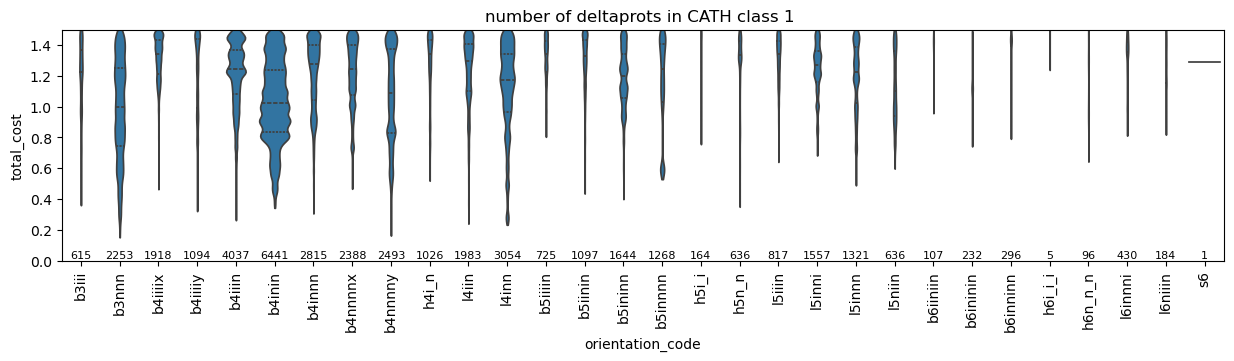

In [ ]:
# seaborn plot over orientation_code
from isambard.specifications.deltaprot import DeltaProt
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots( figsize=(15,3))
sns.violinplot(x="orientation_code",y="total_cost", data=df,cut=0,order=DeltaProt.orientation_codes,ax=ax,inner="quart",bw_adjust=0.5,density_norm="count")
# rorate x labels 90 
ax.set_xticklabels(DeltaProt.orientation_codes, rotation=90)
# above each violin, annotate number of items in the violin 
for i in range(len(DeltaProt.orientation_codes)):
    count = len(df[df["orientation_code"] == DeltaProt.orientation_codes[i]])
    ax.text(i, 0, f"{count}", ha="center", va="bottom", fontsize=8) 
# set title
ax.set_title("number of deltaprots in CATH class 1 ", fontsize=12)
ax.set_ylim(0,1.5)
# save figure to "/home/tadas/code/deltaProteinSearch/outputs/figures"
for ext in ["svg", "png"]:
    fig.savefig(f"/home/tadas/code/deltaProteinSearch/outputs/figures/total_cost_violinplot.{ext}", format=ext, dpi=300, bbox_inches="tight")


plt.show()


In [ ]:

def filter_deltahedral_domains(domains):

    deltaproteins_cath = "1.10"
    deltahedral_domains = []
    for domain in domains:
        if domain["cath"].startswith(deltaproteins_cath):
            deltahedral_domains.append(domain)
        
    print(f"Selected {len(deltahedral_domains)} out of {len(domains)} domains with code: {deltaproteins_cath}. This is {round(len(deltahedral_domains)/len(domains)*100)}% of the domains.")
    print(f'Selected {len(set([i["pdb_code"] for i in deltahedral_domains]))} out of {len(set([i["pdb_code"] for i in domains]))} unique CATH proteins. This is {round(len(set([i["pdb_code"]for i in deltahedral_domains]))/len(set([i["pdb_code"] for i in domains]))*100)}% of the proteins.')
    return deltahedral_domains


def filter_small_domains(domains, amino_acid_num):
    filtered_domains = []

    for domain in domains:
        try:
            size = sum(int(chain['end']) - int(chain['start']) + 1 for chain in domain['chain_info'])
        except:
            print(f'Unclear domain size in  {domain["pdb_code"]}, {domain["chain_info"]}. Excluding the domain')
            # filtered_domains.append(domain)
        if size <= amino_acid_num:
            filtered_domains.append(domain)

    print(f"Filtered {len(filtered_domains)} domains out of {len(domains)} ({round(len(filtered_domains)/len(domains)*100,2)}%)")
    return filtered_domains

def process_domain(domain):
    try:
        pdb_file = get_decompressed_pdb(domain["pdb_code"],biounit=False)
        domain_name = domain["pdb_code"]+"_"+domain["domain"]
        structure = ampal.load_pdb(pdb_file,path=False)
        if structure.__class__ == ampal.assembly.AmpalContainer:
            structure = structure[0]
        domain_structures=[]
        for chain in domain["chain_info"]:
            selection = structure[chain["chain_id"]][int(chain["start"]):int(chain["end"])]
            domain_structures.append(selection)
        return ampal.Assembly(domain_structures,assembly_id=domain_name)
    except FileNotFoundError:
        print(f"File not found for {domain['pdb_code']} in {process_domain.__name__}")
        return None
    except Exception as e:
        print(f"Error processing {domain['pdb_code']} in {process_domain.__name__}: {e}")
        return None

# def store_domains_as_ampal_objects(domains,file_dir,batch_size ):
#     os.makedirs(file_dir, exist_ok=True)
#     # get the existing files in the directory
#     files = os.listdir(file_dir)
#     # extract batch numbers from the file names
#     batch_numbers = get_numbers_in_string_list(files)
#     # find the last batch number
#     last_batch_num = max(batch_numbers) if batch_numbers else 0
#     # split domains into batches
#     domains_batches = batch_list_objects(domains,batch_size)
#     if last_batch_num == len(domains_batches):
#         print("All batches done")
        
#     with ProcessPoolExecutor(max_workers=32) as executor: 
#         # start from the next batch
#         for batch_num, domains_batch in enumerate(domains_batches[last_batch_num:], start=last_batch_num + 1):
#             futures = {executor.submit(process_domain, domain): domain for domain in domains_batch}
#             results_batch = []
#             for future in as_completed(futures):
#                 domain = futures[future]
#                 try:
#                     result = future.result()  # get the results (if any)
#                     results_batch.append(result)
#                 except Exception as exc:
#                     print(f'{domain} generated an exception: {exc}')
                
#             # save the results of the current batch to a file
#             with open(os.path.join(file_dir, f"batch_{batch_num}.pkl"), 'wb') as f:
#                 pickle.dump(results_batch, f)

#             print(f'Completed batch: {batch_num}/{len(domains_batches)}')

def check_dir_size(path):
    def get_folder_size(folder):
        total = 0
        for path, dirs, files in os.walk(folder):
            for f in files:
                fp = os.path.join(path, f)
                total += os.path.getsize(fp)
        return total
    folder_size = get_folder_size(path)
    print("Size of ./deltaProteinAmpalObjects: %.2f MB" % (folder_size / (1024 * 1024)))


def count_hydrophobic_fraction(protein_sequence):
    total_amino_acids = len(protein_sequence)
    if total_amino_acids ==0:
        return 0
    hydrophobic_amino_acids = set('AVLIPMFWGC')  # Hydrophobic amino acids
    hydrophobic_count = sum(1 for aa in protein_sequence if aa in hydrophobic_amino_acids)

    hydrophobic_fraction = hydrophobic_count / total_amino_acids
    return hydrophobic_fraction

In [72]:
import numpy as np
import plotly.graph_objects as go



coords = np.array([i["CA"].array for i in assembly1.get_monomers()])
# plot coords with plotly connected by lines 


# Create a 3D scatter plot with lines and markers
fig = go.Figure(data=[go.Scatter3d(
    x=coords[:, 0],
    y=coords[:, 1],
    z=coords[:, 2],
    mode='lines+markers',
    line=dict(color='blue', width=2),
    marker=dict(size=4, color='red')
)])

# Update layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    title="3D Plot of CA Coordinates"
)

fig.show()
